This is an archive of an analysis on Parkinson's disease that leveraged data from Kaggle. https://www.kaggle.com/datasets/rabieelkharoua/parkinsons-disease-dataset-analysis

# Importing data and pre-analysis data processing

Import Pandas and Numpy library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from IPython.display import display
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

from sklearn.metrics import ConfusionMatrixDisplay


from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SequentialFeatureSelector

import statsmodels.api as sm

from xgboost import XGBClassifier




Import Parkinson's disease dataset

In [ ]:
## this code is adapted from the tutorial https://colab.research.google.com/drive/1lCRaaUyQq2o4-loB3WfNDKZbpavLGE4S?usp=sharing#scrollTo=9QUFwk0zglMM

%%time
!pip install googledrivedownloader #black magic
from google_drive_downloader import GoogleDriveDownloader as gdd

#https://drive.google.com/file/d/1L4kQ7AtgIhiOY4tCu7A05QO9XrEB6Upp/view?usp=drive_link
gdd.download_file_from_google_drive(file_id="1L4kQ7AtgIhiOY4tCu7A05QO9XrEB6Upp",
                                    dest_path="./parkinsons_disease_data.csv",
                                    unzip=False)
df = pd.read_csv("parkinsons_disease_data.csv")
df_original = df.copy() #create a backup of the original dataframe (just in case we mess up...)

CPU times: user 537 ms, sys: 63.1 ms, total: 600 ms
Wall time: 16.2 s


Test that the dataset works

In [ ]:
# Confirmed that dataset is clean in terms on non-null values

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2105 entries, 0 to 2104
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PatientID                 2105 non-null   int64  
 1   Age                       2105 non-null   int64  
 2   Gender                    2105 non-null   int64  
 3   Ethnicity                 2105 non-null   int64  
 4   EducationLevel            2105 non-null   int64  
 5   BMI                       2105 non-null   float64
 6   Smoking                   2105 non-null   int64  
 7   AlcoholConsumption        2105 non-null   float64
 8   PhysicalActivity          2105 non-null   float64
 9   DietQuality               2105 non-null   float64
 10  SleepQuality              2105 non-null   float64
 11  FamilyHistoryParkinsons   2105 non-null   int64  
 12  TraumaticBrainInjury      2105 non-null   int64  
 13  Hypertension              2105 non-null   int64  
 14  Diabetes

In [ ]:
# Descriptive statistics of the whole dataset
pd.set_option('display.max_columns', 35)
df.describe()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,FamilyHistoryParkinsons,TraumaticBrainInjury,Hypertension,Diabetes,Depression,Stroke,SystolicBP,DiastolicBP,CholesterolTotal,CholesterolLDL,CholesterolHDL,CholesterolTriglycerides,UPDRS,MoCA,FunctionalAssessment,Tremor,Rigidity,Bradykinesia,PosturalInstability,SpeechProblems,SleepDisorders,Constipation,Diagnosis
count,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000,2105.000000
mean,4110.000000,69.601900,0.492637,0.692637,1.337292,27.209493,0.296437,10.040413,5.016674,4.912901,6.996639,0.145843,0.106413,0.145843,0.148219,0.205226,0.048931,133.719715,90.249881,226.860840,126.147858,59.670352,222.940500,101.415318,15.094314,4.989694,0.431829,0.252732,0.207601,0.138717,0.295012,0.245131,0.296912,0.619477
std,607.805479,11.594511,0.500065,1.003827,0.895840,7.208099,0.456795,5.687014,2.890919,2.872115,1.753065,0.353033,0.308439,0.353033,0.355401,0.403962,0.215775,26.502355,17.061488,43.589406,43.407036,23.370920,101.895822,56.591448,8.643014,2.933877,0.495449,0.434682,0.405686,0.345733,0.456156,0.430267,0.457006,0.485631
min,3058.000000,50.000000,0.000000,0.000000,0.000000,15.008333,0.000000,0.002228,0.004157,0.000011,4.000497,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,90.000000,60.000000,150.062698,50.022828,20.027981,50.113604,0.028441,0.021191,0.001505,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3584.000000,60.000000,0.000000,0.000000,1.000000,20.782176,0.000000,5.150278,2.455703,2.478503,5.488864,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,110.000000,75.000000,189.385178,88.841960,39.538643,132.520174,53.048148,7.517160,2.415890,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4110.000000,70.000000,0.000000,0.000000,1.000000,27.184571,0.000000,10.070337,5.031550,4.825187,6.929819,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,133.000000,91.000000,228.528256,126.884570,59.343357,222.802452,102.561023,14.963574,4.983227,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,4636.000000,80.000000,1.000000,1.000000,2.000000,33.462452,1.000000,14.829565,7.512795,7.381487,8.558719,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,157.000000,105.000000,264.608100,163.912782,79.366628,311.699109,149.831682,22.608362,7.484220,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000
max,5162.000000,89.000000,1.000000,3.000000,3.000000,39.999887,1.000000,19.988866,9.995255,9.995864,9.999821,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,179.000000,119.000000,299.963074,199.985981,99.982265,399.975022,198.953604,29.970107,9.992697,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Confirmed that our dataset contains 2,105 patients and 35 columns

df


,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,FamilyHistoryParkinsons,TraumaticBrainInjury,Hypertension,Diabetes,Depression,Stroke,SystolicBP,DiastolicBP,CholesterolTotal,CholesterolLDL,CholesterolHDL,CholesterolTriglycerides,UPDRS,MoCA,FunctionalAssessment,Tremor,Rigidity,Bradykinesia,PosturalInstability,SpeechProblems,SleepDisorders,Constipation,Diagnosis,DoctorInCharge
0,3058,85,0,3,1,19.619878,0,5.108241,1.380660,3.893969,9.283194,0,0,0,0,0,0,129,60,222.842278,148.125623,37.867776,337.307114,6.458713,29.181289,1.572427,1,0,0,0,0,0,0,0,DrXXXConfid
1,3059,75,0,0,2,16.247339,1,6.027648,8.409804,8.513428,5.602470,0,0,0,0,0,0,163,76,210.501133,153.756463,77.228117,264.635521,37.306703,12.332639,4.787551,0,1,0,1,0,1,0,1,DrXXXConfid
2,3060,70,1,0,0,15.368239,0,2.242135,0.213275,6.498805,9.929824,0,0,0,1,0,0,113,93,287.387996,118.702600,85.588304,395.662649,67.838170,29.927783,2.130686,1,0,0,0,1,0,1,1,DrXXXConfid
3,3061,52,0,0,0,15.454557,0,5.997788,1.375045,6.715033,4.196189,0,0,0,0,0,0,146,78,280.339546,136.299186,51.869626,362.189688,52.964696,21.304268,3.391288,1,1,1,0,0,0,1,1,DrXXXConfid
4,3062,87,0,0,1,18.616042,0,9.775243,1.188607,4.657572,9.363925,0,0,0,0,0,0,115,94,284.014151,108.449452,25.069418,149.956586,21.804880,8.336364,3.200969,0,0,0,1,0,1,0,0,DrXXXConfid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2100,5158,87,1,0,2,38.483841,0,12.674393,5.325900,5.947278,6.296231,0,0,1,0,0,0,92,98,191.372707,98.730980,93.269555,161.291730,187.887925,28.634010,8.076254,1,0,0,0,1,1,0,0,DrXXXConfid
2101,5159,67,0,0,1,33.694396,1,0.977018,0.108599,4.825187,6.342325,1,0,0,0,0,0,103,96,150.188647,112.063230,47.524626,240.086616,172.325253,13.106537,1.665751,0,0,0,1,0,1,1,1,DrXXXConfid
2102,5160,65,0,0,2,22.829631,0,6.152286,5.775103,0.334244,9.740019,1,0,0,1,0,1,168,79,159.351155,61.543591,72.765698,222.231014,111.851581,26.527734,4.785614,0,0,0,0,1,1,0,1,DrXXXConfid
2103,5161,61,1,0,0,16.871030,1,0.292094,2.280475,9.598513,8.289390,0,0,0,0,0,0,129,97,232.240473,53.029891,99.945560,167.980928,144.474453,19.873404,8.378979,1,0,1,0,0,1,1,1,DrXXXConfid


In [ ]:
#check the present of missing value
df.isnull().sum()

,0
PatientID,0
Age,0
Gender,0
Ethnicity,0
EducationLevel,0
BMI,0
Smoking,0
AlcoholConsumption,0
PhysicalActivity,0
DietQuality,0


In [ ]:
df.duplicated().sum()

0

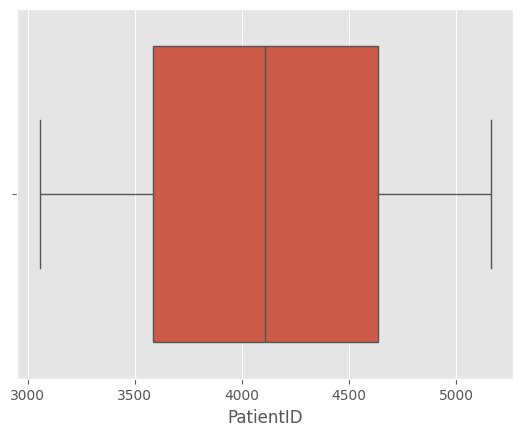

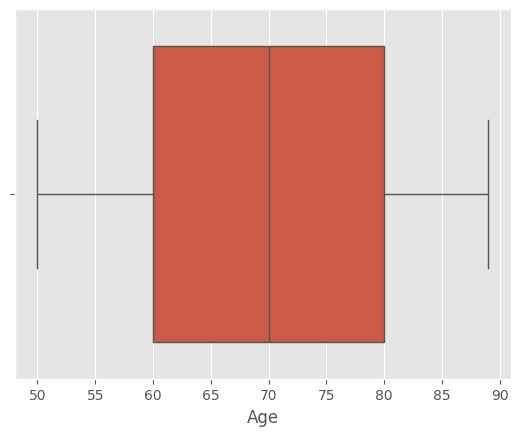

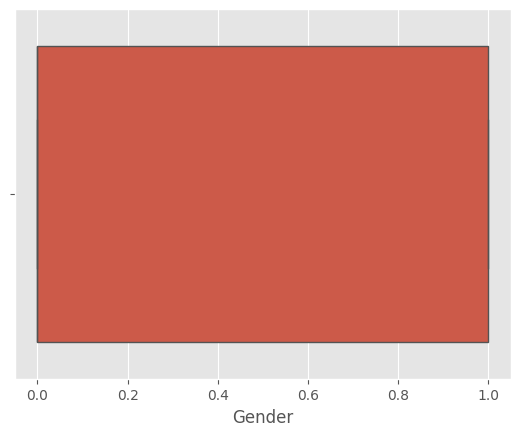

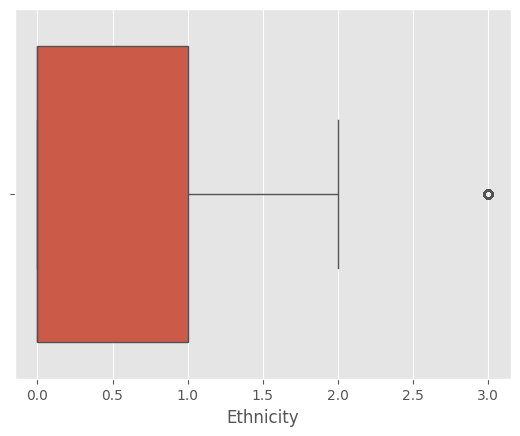

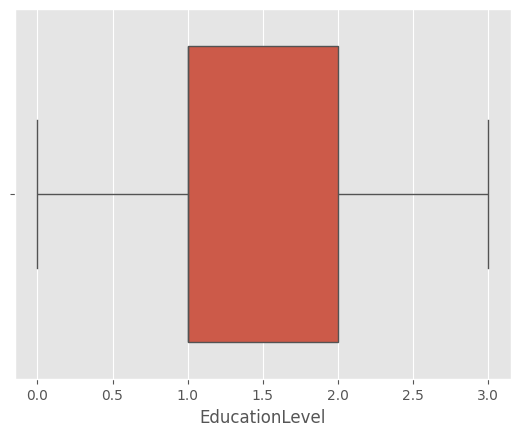

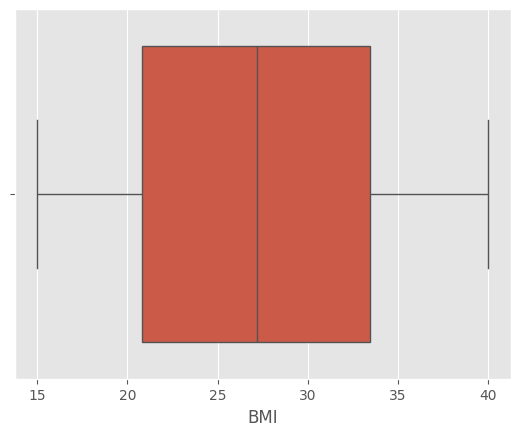

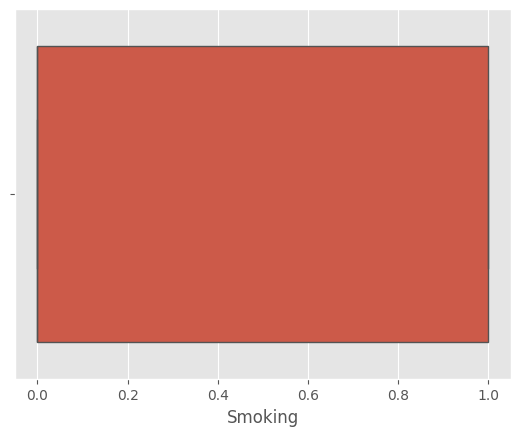

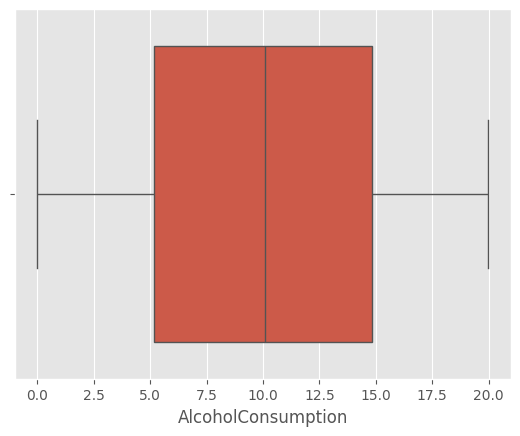

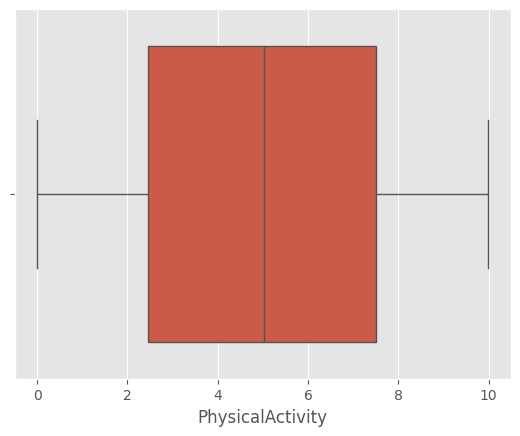

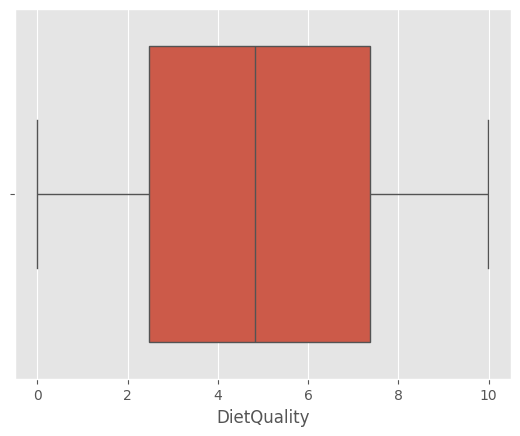

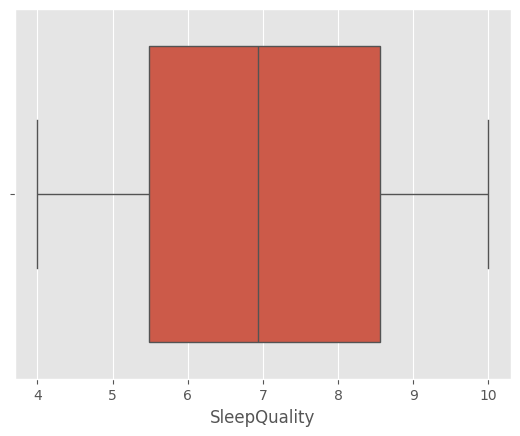

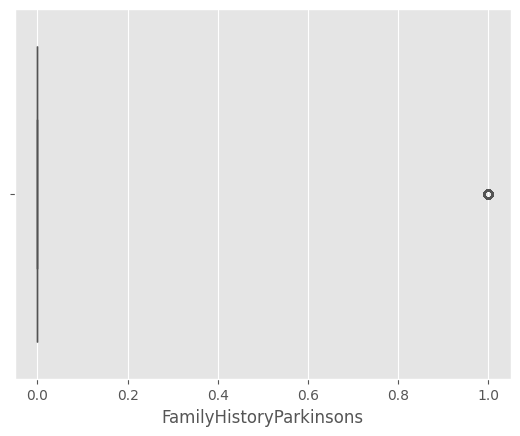

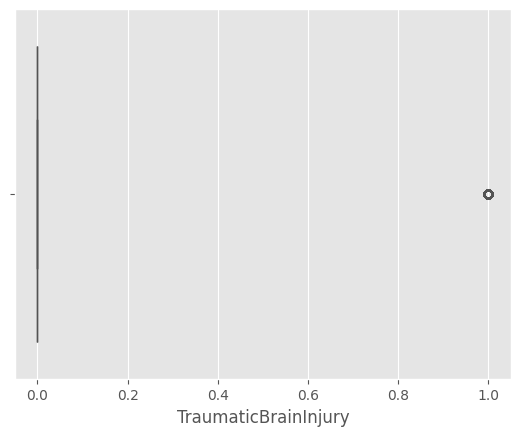

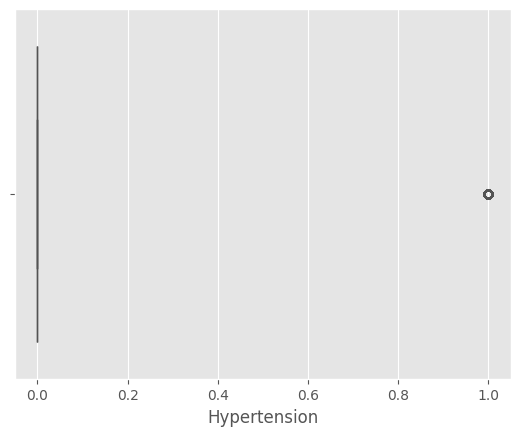

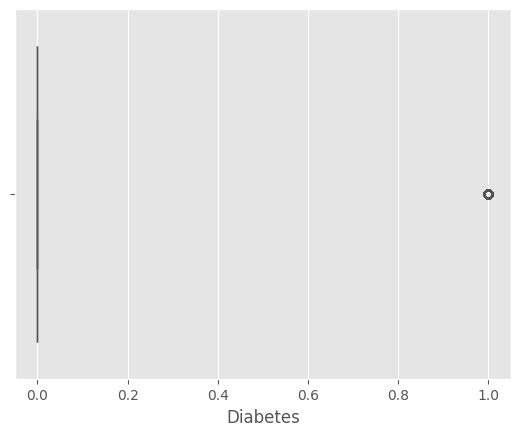

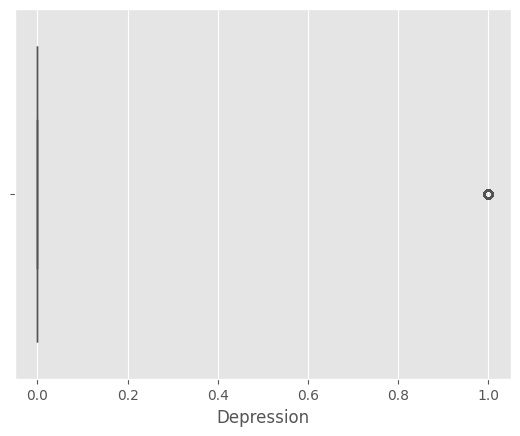

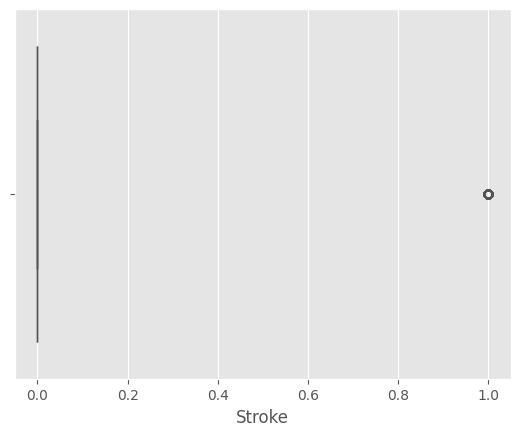

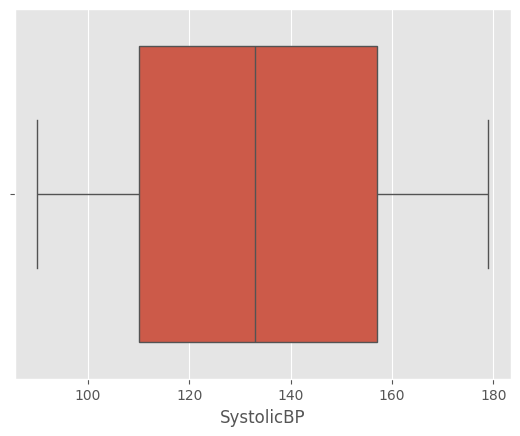

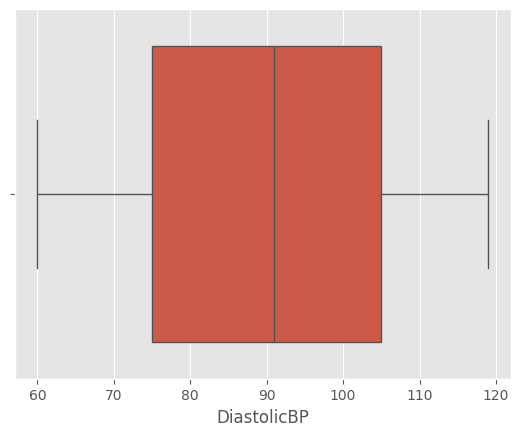

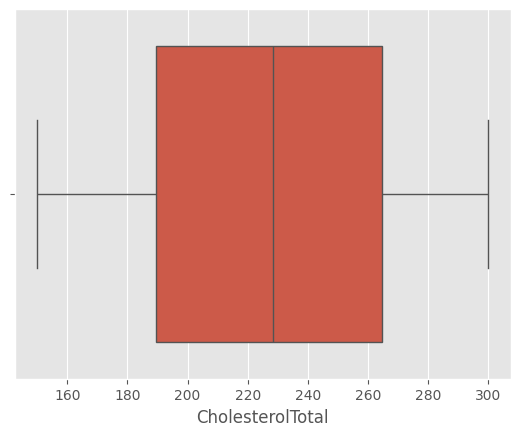

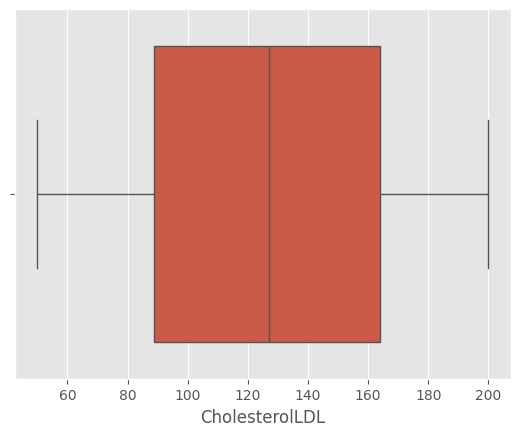

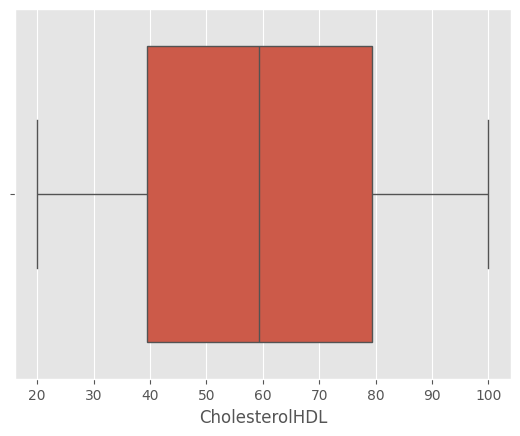

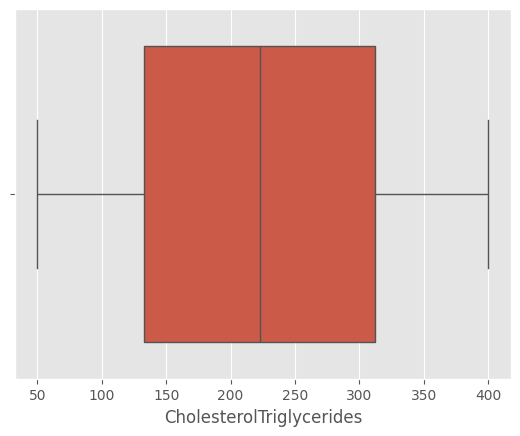

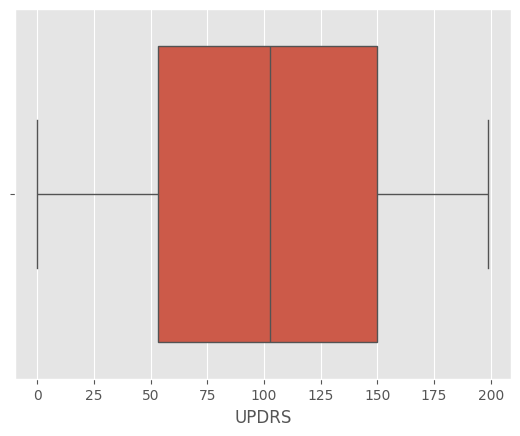

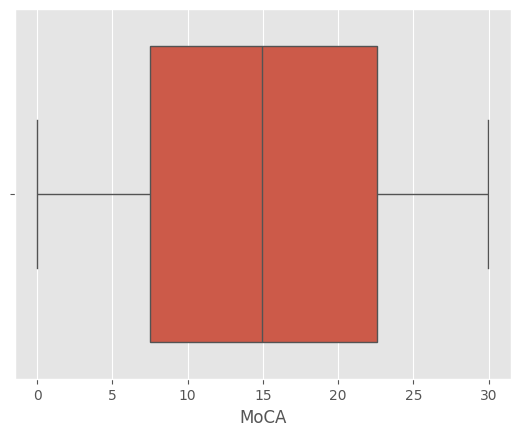

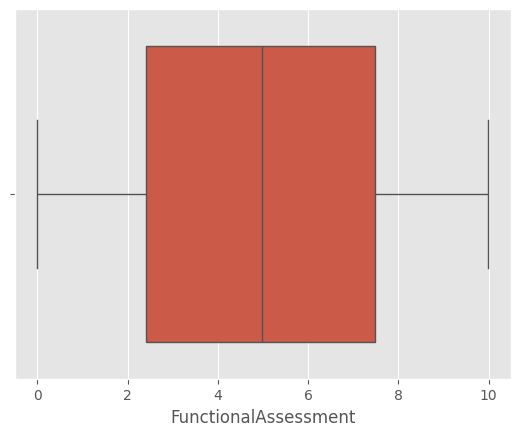

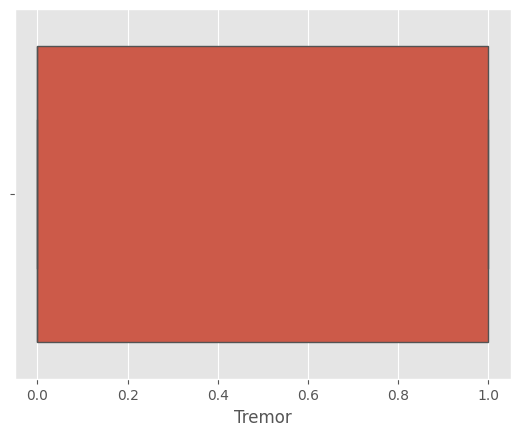

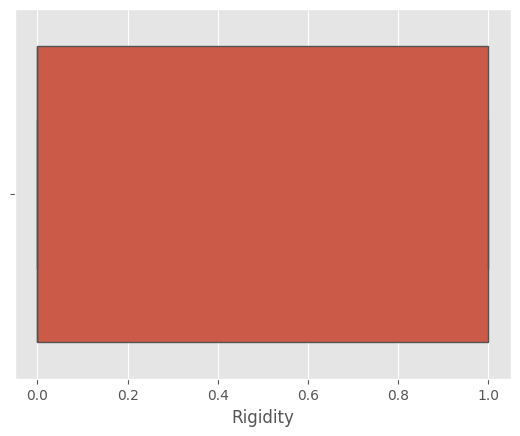

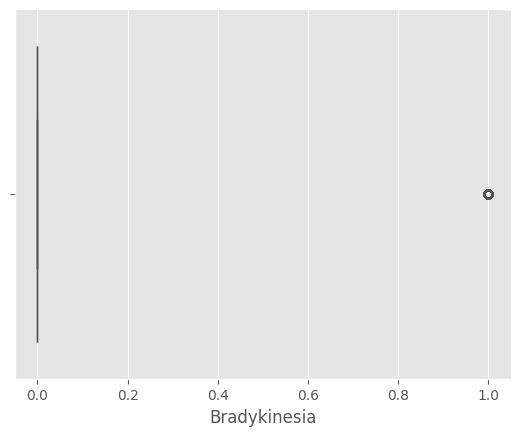

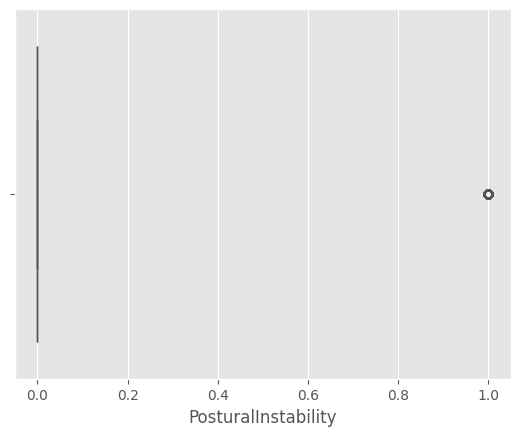

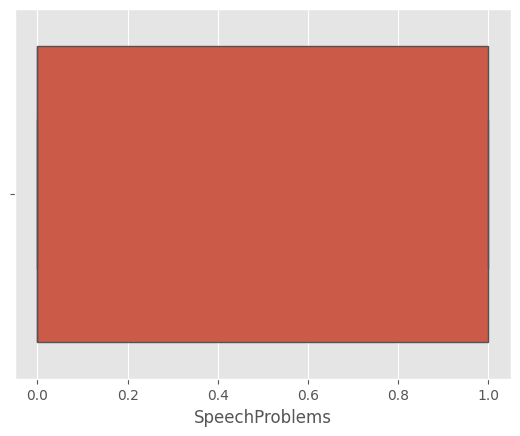

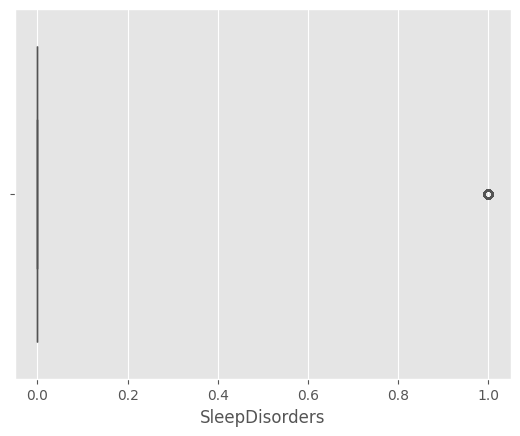

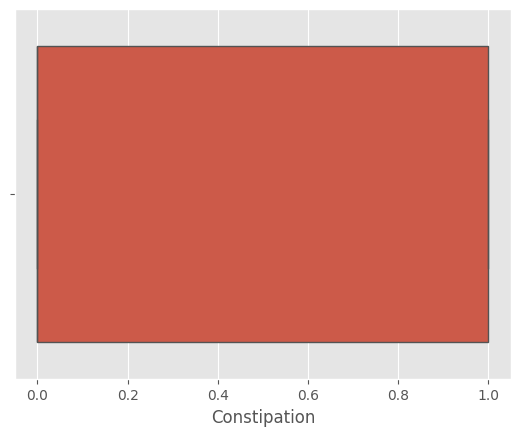

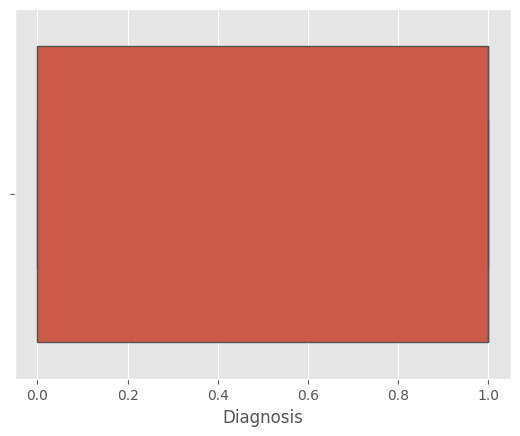

In [ ]:
# Checking for outliers

for column in df.select_dtypes(include=['float64', 'int64']).columns:
    sns.boxplot(x=df[column])
    plt.show()

# Descriptive statistics

In [ ]:
# Review of non-normal distribution of ethnicity
# 0: Caucasian
# 1: African American
# 2: Asian
# 3: Other

df.groupby('Ethnicity').count()['PatientID']

,PatientID
Ethnicity,
0,1270
1,425
2,197
3,213


In [ ]:
# How many of these 2,105 patients have been diagnosed with Parkison's disease?
# Diagnosis status for Parkinson's Disease, where 0 indicates No and 1 indicates Yes.

df['Diagnosis'].value_counts()

,count
Diagnosis,
1,1304
0,801


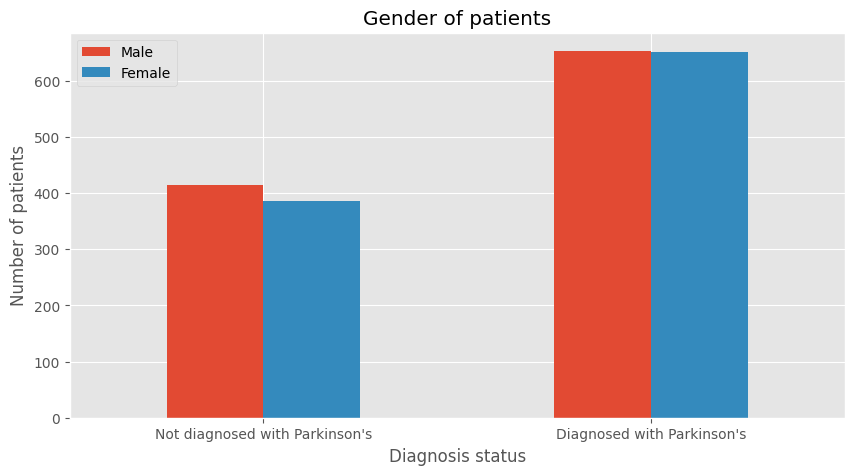

In [ ]:
# Plot diagnosed patients by gender - are there more males (gender = 0) than females (gender = 1) diagnosed with Parkinson's in our dataset?

Diagnosis_Analysis = pd.crosstab(index=df["Diagnosis"], columns=df["Gender"], values=df["PatientID"], aggfunc="count")

fig, axes = plt.subplots(figsize=(10,5))

Diagnosis_Analysis.plot(kind='bar', ax=axes);

axes.legend(["Male", "Female"]);

axes.set_xlabel("Diagnosis status")
axes.set_ylabel("Number of patients")

axes.set_title("Gender of patients")

axes.set_xticklabels(["Not diagnosed with Parkinson's", "Diagnosed with Parkinson's"], rotation=0)

plt.rcParams.update({'font.size': 18})

In [ ]:
# Remove DoctorInCharge column from the rest of dataset

df.drop("DoctorInCharge", inplace=True, axis=1)

In [ ]:
# Create age bins to group patients by age groups

ageBins = [50,60,70,80,90]
ageBin_labels = ["50-59","60-69","70-79","80-89",]
df["AgeGroup"] = pd.cut(df['Age'],ageBins,right=False,labels =ageBin_labels)
df

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,FamilyHistoryParkinsons,TraumaticBrainInjury,Hypertension,Diabetes,Depression,Stroke,SystolicBP,DiastolicBP,CholesterolTotal,CholesterolLDL,CholesterolHDL,CholesterolTriglycerides,UPDRS,MoCA,FunctionalAssessment,Tremor,Rigidity,Bradykinesia,PosturalInstability,SpeechProblems,SleepDisorders,Constipation,Diagnosis,AgeGroup
0,3058,85,0,3,1,19.619878,0,5.108241,1.380660,3.893969,9.283194,0,0,0,0,0,0,129,60,222.842278,148.125623,37.867776,337.307114,6.458713,29.181289,1.572427,1,0,0,0,0,0,0,0,80-89
1,3059,75,0,0,2,16.247339,1,6.027648,8.409804,8.513428,5.602470,0,0,0,0,0,0,163,76,210.501133,153.756463,77.228117,264.635521,37.306703,12.332639,4.787551,0,1,0,1,0,1,0,1,70-79
2,3060,70,1,0,0,15.368239,0,2.242135,0.213275,6.498805,9.929824,0,0,0,1,0,0,113,93,287.387996,118.702600,85.588304,395.662649,67.838170,29.927783,2.130686,1,0,0,0,1,0,1,1,70-79
3,3061,52,0,0,0,15.454557,0,5.997788,1.375045,6.715033,4.196189,0,0,0,0,0,0,146,78,280.339546,136.299186,51.869626,362.189688,52.964696,21.304268,3.391288,1,1,1,0,0,0,1,1,50-59
4,3062,87,0,0,1,18.616042,0,9.775243,1.188607,4.657572,9.363925,0,0,0,0,0,0,115,94,284.014151,108.449452,25.069418,149.956586,21.804880,8.336364,3.200969,0,0,0,1,0,1,0,0,80-89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2100,5158,87,1,0,2,38.483841,0,12.674393,5.325900,5.947278,6.296231,0,0,1,0,0,0,92,98,191.372707,98.730980,93.269555,161.291730,187.887925,28.634010,8.076254,1,0,0,0,1,1,0,0,80-89
2101,5159,67,0,0,1,33.694396,1,0.977018,0.108599,4.825187,6.342325,1,0,0,0,0,0,103,96,150.188647,112.063230,47.524626,240.086616,172.325253,13.106537,1.665751,0,0,0,1,0,1,1,1,60-69
2102,5160,65,0,0,2,22.829631,0,6.152286,5.775103,0.334244,9.740019,1,0,0,1,0,1,168,79,159.351155,61.543591,72.765698,222.231014,111.851581,26.527734,4.785614,0,0,0,0,1,1,0,1,60-69
2103,5161,61,1,0,0,16.871030,1,0.292094,2.280475,9.598513,8.289390,0,0,0,0,0,0,129,97,232.240473,53.029891,99.945560,167.980928,144.474453,19.873404,8.378979,1,0,1,0,0,1,1,1,60-69


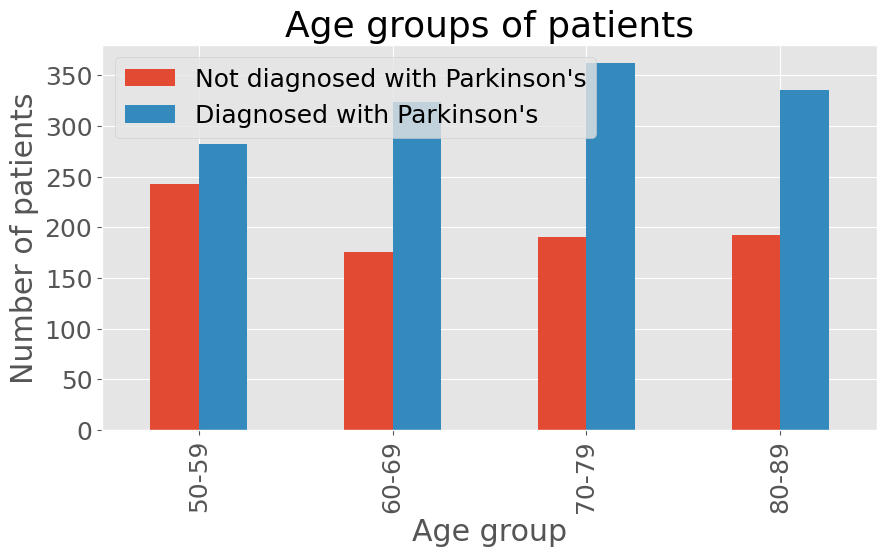

In [ ]:
# Count the number of diagnosed patients by age groups

Age_Analysis = pd.crosstab(index=df["AgeGroup"], columns=df["Diagnosis"], values=df["PatientID"], aggfunc="count")

fig, axes = plt.subplots(figsize=(10,5))

Age_Analysis.plot(kind='bar', ax=axes);

axes.legend(["Not diagnosed with Parkinson's", "Diagnosed with Parkinson's"]);

axes.set_xlabel("Age group")
axes.set_ylabel("Number of patients")

axes.set_title("Age groups of patients")
plt.rcParams.update({'font.size': 12})


Text(0.5, 1.0, "Symptoms of diagnosed and undiagnosed patients with Parkinson's disease")

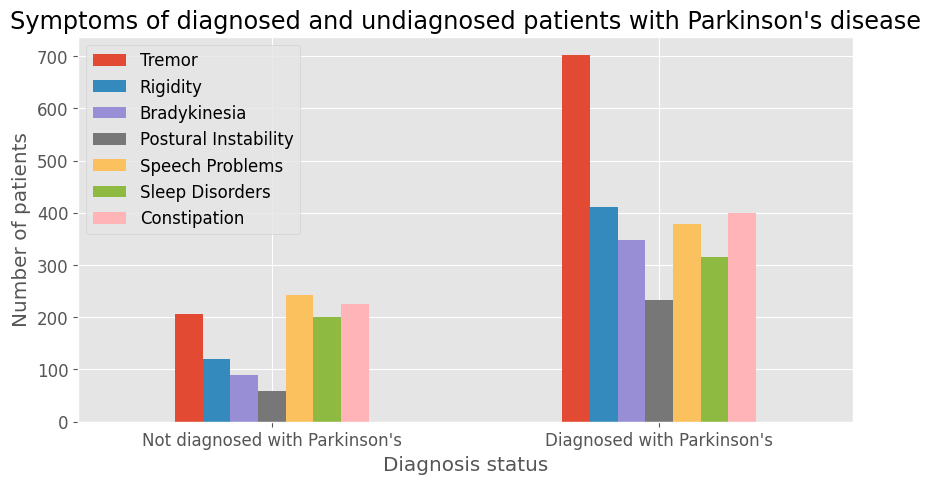

In [ ]:
# Symptoms of patients diagnosed and undiagnosed with Parkinson's disease

df_patients_with_parkinsons = df[df["Diagnosis"]==1]

#df_patients_with_parkinsons['Tremor', 'Rigidity']

Symptom_Analysis = df[["Diagnosis", "Tremor", "Rigidity", "Bradykinesia", "PosturalInstability", "SpeechProblems", "SleepDisorders", "Constipation"]].groupby("Diagnosis").agg(["sum"])

fig, axes = plt.subplots(figsize=(10,5))

#.plot(kind='bar', figsize=(10,5), title="Symptoms of diagnosed and undiagnosed patients with Parkinson's disease", xlabel="Diagnosis status", ylabel="Number of patients")

# Count the number of diagnosed patients by age groups
#Symptom_Analysis = pd.crosstab(index=df_patients_with_parkinsons["Tremor", "Rigidity"], columns=df["PatientID"], values=df["Tremor", "Rigidity"], aggfunc="sum")

Symptom_Analysis.plot(kind='bar', ax=axes);

axes.legend(["Tremor", "Rigidity", "Bradykinesia", "Postural Instability", "Speech Problems", "Sleep Disorders", "Constipation" ]);

axes.set_xticklabels(["Not diagnosed with Parkinson's", "Diagnosed with Parkinson's"], rotation=0)

axes.set_xlabel("Diagnosis status")
axes.set_ylabel("Number of patients")

axes.set_title("Symptoms of diagnosed and undiagnosed patients with Parkinson's disease")
#plt.rcParams.update({'font.size': 12})

Text(0.5, 1.0, "Medical history of diagnosed and undiagnosed patients with Parkinson's disease")

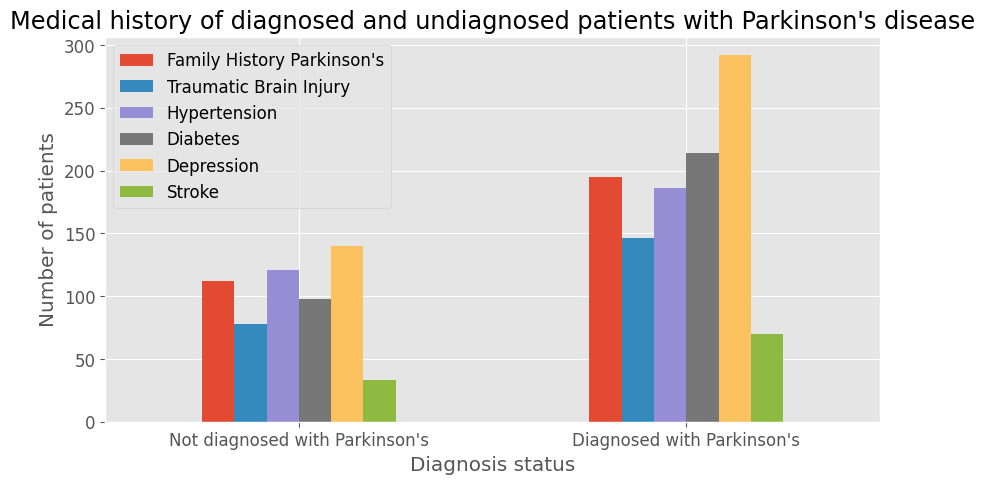

In [ ]:
# Medical history: FamilyHistoryParkinsons, TraumaticBrainInjury, Hypertension, Diabetes, Depression, Stroke


Medical_History_Analysis = df[["Diagnosis", "FamilyHistoryParkinsons", "TraumaticBrainInjury", "Hypertension", "Diabetes", "Depression", "Stroke"]].groupby("Diagnosis").agg(["sum"])

fig, axes = plt.subplots(figsize=(10,5))

#.plot(kind='bar', figsize=(10,5), title="Symptoms of diagnosed and undiagnosed patients with Parkinson's disease", xlabel="Diagnosis status", ylabel="Number of patients")

# Count the number of diagnosed patients by age groups
#Symptom_Analysis = pd.crosstab(index=df_patients_with_parkinsons["Tremor", "Rigidity"], columns=df["PatientID"], values=df["Tremor", "Rigidity"], aggfunc="sum")

Medical_History_Analysis.plot(kind='bar', ax=axes);

axes.legend(["Family History Parkinson's", "Traumatic Brain Injury", "Hypertension", "Diabetes", "Depression", "Stroke" ]);

axes.set_xticklabels(["Not diagnosed with Parkinson's", "Diagnosed with Parkinson's"], rotation=0)

axes.set_xlabel("Diagnosis status")
axes.set_ylabel("Number of patients")


axes.set_title("Medical history of diagnosed and undiagnosed patients with Parkinson's disease")
#plt.rcParams.update({'font.size': 12})

In [ ]:
# Count of diagnosed patients (sum column) by age group
df[["Diagnosis", "AgeGroup"]].groupby("AgeGroup").agg(["count", "sum"])

<ipython-input-17-76aa7ead4600>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[["Diagnosis", "AgeGroup"]].groupby("AgeGroup").agg(["count", "sum"])


Diagnosis     
             count  sum
AgeGroup               
50-59          525  282
60-69          500  324
70-79          552  362
80-89          528  336

# Correlative analysis

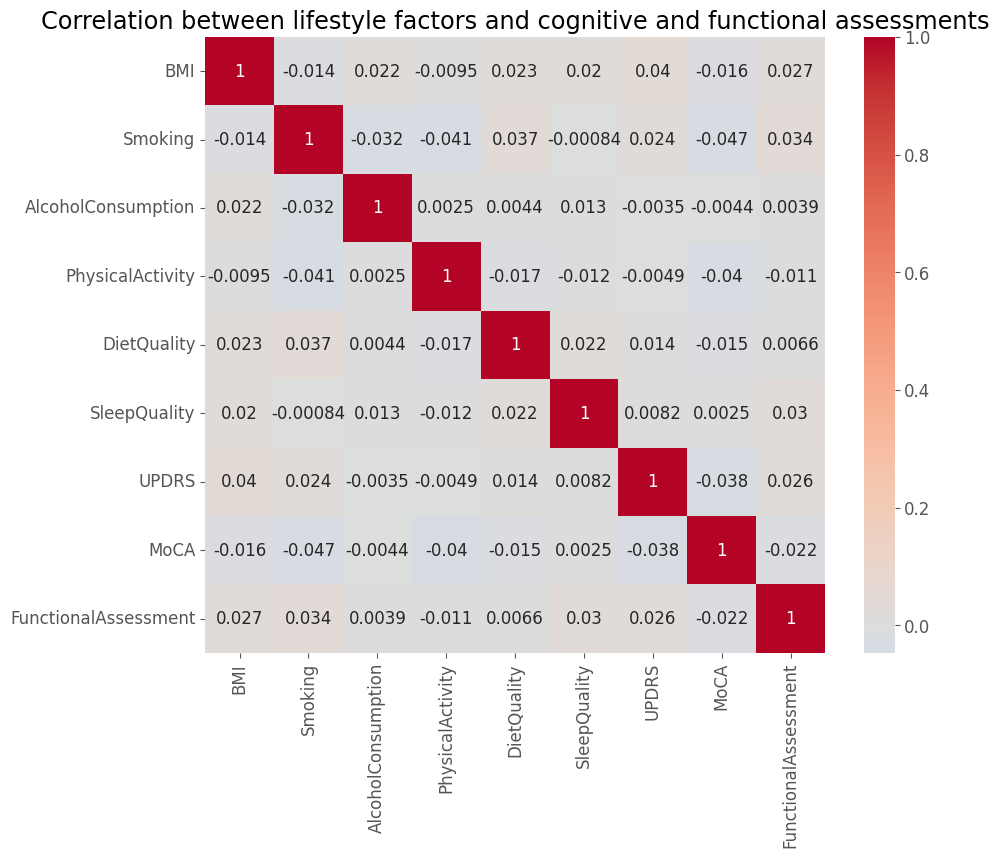

In [ ]:
# Correlation analysis of lifestyle factors and cognitive and functional assessments

lifestyle_df_patients_with_parkinsons = df_patients_with_parkinsons[["BMI", "Smoking","AlcoholConsumption","PhysicalActivity","DietQuality","SleepQuality", "UPDRS", "MoCA", "FunctionalAssessment"]]
#pd.plotting.scatter_matrix(lifestyle_df_patients_with_parkinsons, alpha=0.2)

#df_patients_with_parkinsons["BMI"].corr(df_patients_with_parkinsons["UPDRS"])

#print(lifestyle_df_patients_with_parkinsons.corr())

lifestyle_df_patients_with_parkinsons_corr = lifestyle_df_patients_with_parkinsons.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(lifestyle_df_patients_with_parkinsons_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between lifestyle factors and cognitive and functional assessments')
plt.show()


In [ ]:
lifestyle = df[["BMI", "Smoking","AlcoholConsumption","PhysicalActivity","DietQuality","SleepQuality","Diagnosis"]]
lifestyle

,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,Diagnosis
0,19.619878,0,5.108241,1.380660,3.893969,9.283194,0
1,16.247339,1,6.027648,8.409804,8.513428,5.602470,1
2,15.368239,0,2.242135,0.213275,6.498805,9.929824,1
3,15.454557,0,5.997788,1.375045,6.715033,4.196189,1
4,18.616042,0,9.775243,1.188607,4.657572,9.363925,0
...,...,...,...,...,...,...,...
2100,38.483841,0,12.674393,5.325900,5.947278,6.296231,0
2101,33.694396,1,0.977018,0.108599,4.825187,6.342325,1
2102,22.829631,0,6.152286,5.775103,0.334244,9.740019,1
2103,16.871030,1,0.292094,2.280475,9.598513,8.289390,1


In [ ]:
diagnosedlifestyle = lifestyle[lifestyle["Diagnosis"] == 1]
diagnosedlifestyle

,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,SleepQuality,Diagnosis
1,16.247339,1,6.027648,8.409804,8.513428,5.602470,1
2,15.368239,0,2.242135,0.213275,6.498805,9.929824,1
3,15.454557,0,5.997788,1.375045,6.715033,4.196189,1
7,36.758282,1,19.988866,3.891749,3.421960,7.895866,1
8,22.380587,1,7.293288,2.595670,4.784827,4.170470,1
...,...,...,...,...,...,...,...
2098,19.805534,0,18.604330,1.826044,5.456645,5.169897,1
2099,31.341888,0,3.434399,2.614193,2.786705,4.615461,1
2101,33.694396,1,0.977018,0.108599,4.825187,6.342325,1
2102,22.829631,0,6.152286,5.775103,0.334244,9.740019,1


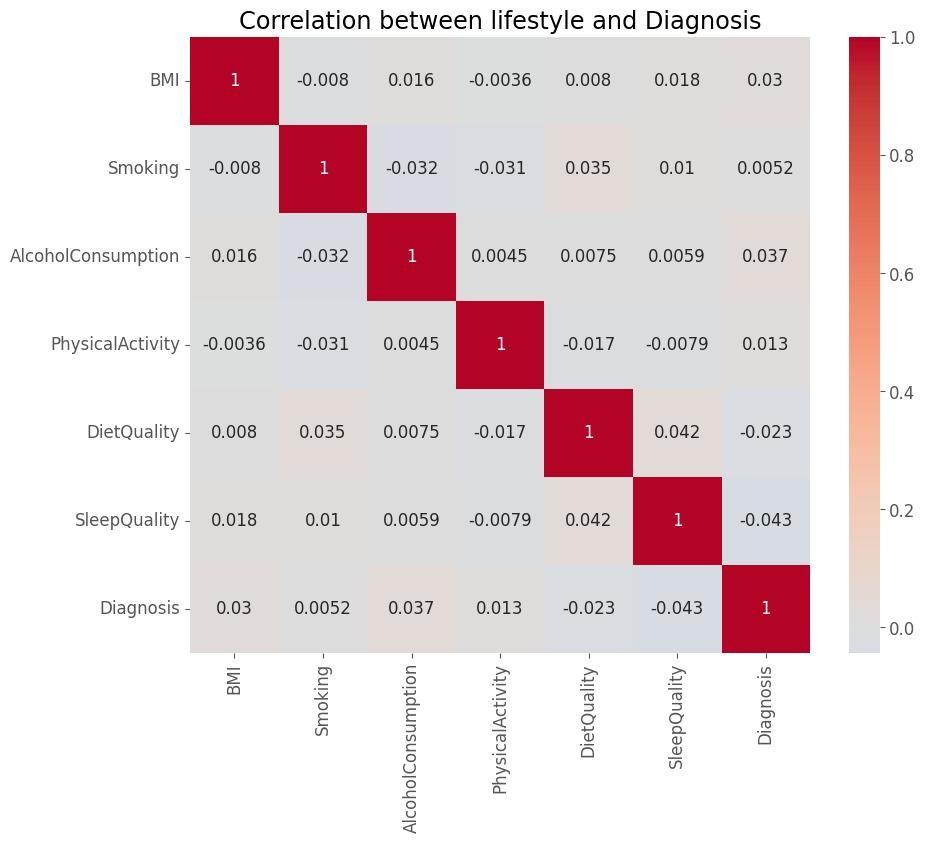

In [ ]:

# Correlation between symptoms and diagnosis
lifestyle_diagnosis_corr = lifestyle.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(lifestyle_diagnosis_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between lifestyle and Diagnosis')
plt.show()

In [ ]:
medicalHistory = df[["FamilyHistoryParkinsons", "TraumaticBrainInjury","Hypertension","Diabetes","Depression","Stroke","Diagnosis"]]
medicalHistory

,FamilyHistoryParkinsons,TraumaticBrainInjury,Hypertension,Diabetes,Depression,Stroke,Diagnosis
0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1
2,0,0,0,1,0,0,1
3,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
2100,0,0,1,0,0,0,0
2101,1,0,0,0,0,0,1
2102,1,0,0,1,0,1,1
2103,0,0,0,0,0,0,1


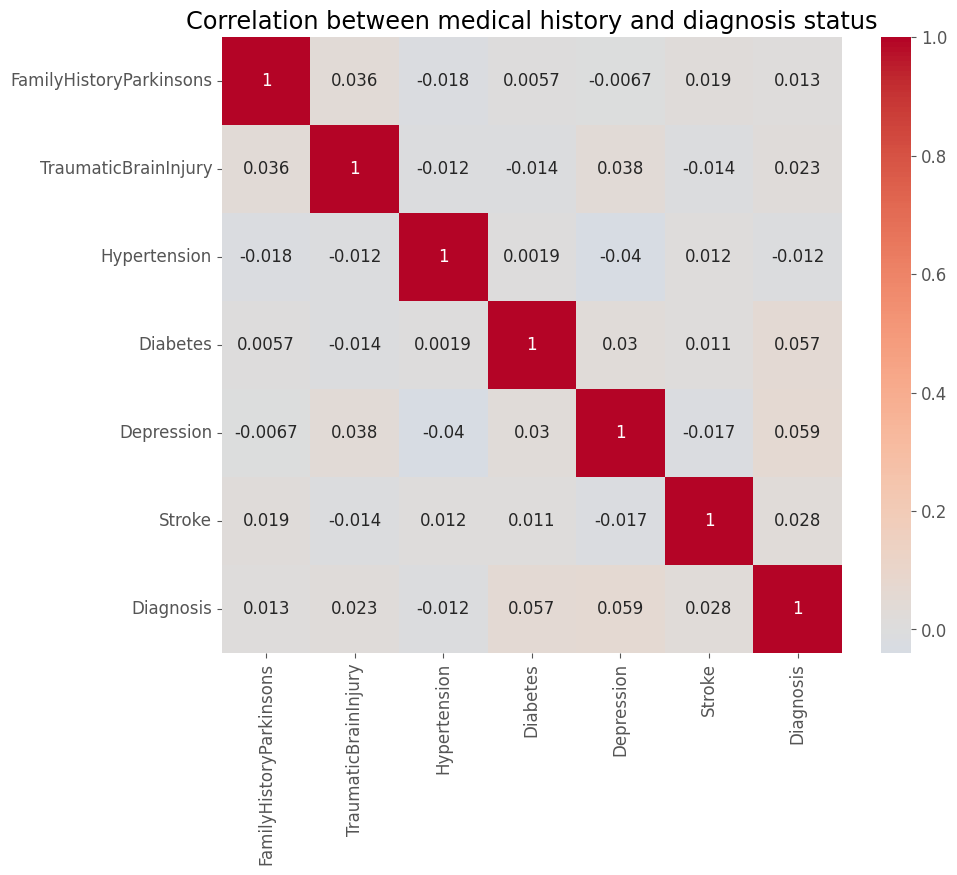

In [ ]:
history_diagnosis_corr = medicalHistory.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(history_diagnosis_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between medical history and diagnosis status')
plt.show()

In [ ]:
medicalHistory[["Hypertension", "Diagnosis"]].groupby("Diagnosis").agg(["sum","count","mean"])

Hypertension                
                   sum count      mean
Diagnosis                             
0                  121   801  0.151061
1                  186  1304  0.142638

In [ ]:
medicalHistory[["Stroke", "Diagnosis"]].groupby("Diagnosis").agg(["sum","count","mean"])

Stroke                
             sum count      mean
Diagnosis                       
0             33   801  0.041199
1             70  1304  0.053681

In [ ]:
medicalHistory[["Diabetes", "Diagnosis"]].groupby("Diagnosis").agg(["sum","count","mean"])

Diabetes                
               sum count      mean
Diagnosis                         
0               98   801  0.122347
1              214  1304  0.164110

In [ ]:
# Calculate the number of patients with hypertension
hypertension_patients = df['Hypertension'].sum()

# Calculate the total number of patients
total_patients = len(df)

# Calculate the percentage of patients with hypertension
hypertension_percentage = (hypertension_patients / total_patients) * 100

# Print the results
print(f"Number of patients with hypertension: {hypertension_patients}")
print(f"Total number of patients: {total_patients}")
print(f"Percentage of patients with hypertension: {hypertension_percentage:.2f}%")

Number of patients with hypertension: 307
Total number of patients: 2105
Percentage of patients with hypertension: 14.58%


In [ ]:
# Filter the data for patients with hypertension
hypertension_df = df[df['Hypertension'] == 1]

# Calculate the number of patients with hypertension diagnosed with Parkinson's
diagnosed_with_hypertension = hypertension_df['Diagnosis'].sum()

# Calculate the total number of patients with hypertension
total_with_hypertension = hypertension_df.shape[0]

# Calculate the percentage of patients with hypertension diagnosed with Parkinson's
percentage_diagnosed_with_hypertension = (diagnosed_with_hypertension / total_with_hypertension) * 100

# Print the results
print(f"Number of patients with hypertension diagnosed with Parkinson's: {diagnosed_with_hypertension}")
print(f"Percentage of patients with hypertension diagnosed with Parkinson's: {percentage_diagnosed_with_hypertension:.2f}%")

Number of patients with hypertension diagnosed with Parkinson's: 186
Percentage of patients with hypertension diagnosed with Parkinson's: 60.59%


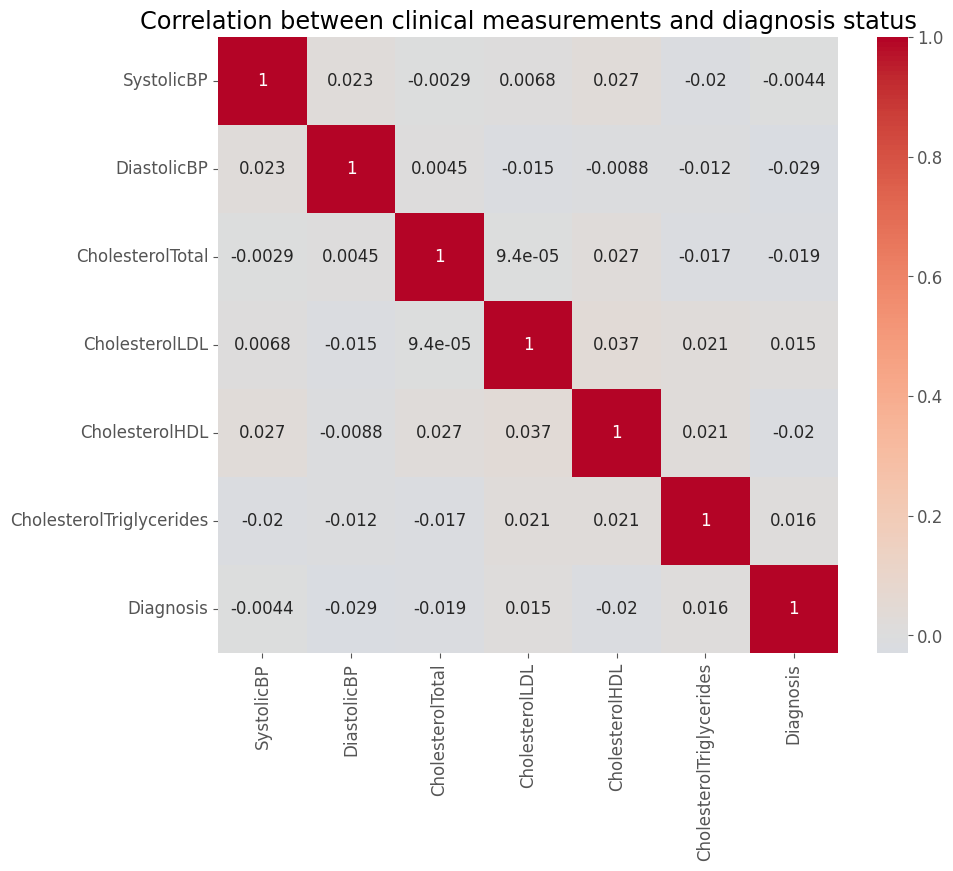

In [ ]:
clinical = ['SystolicBP', 'DiastolicBP', 'CholesterolTotal', 'CholesterolLDL', 'CholesterolHDL', 'CholesterolTriglycerides']
clinical_diagnosis_corr = df[clinical + ['Diagnosis']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(clinical_diagnosis_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between clinical measurements and diagnosis status')
plt.show()

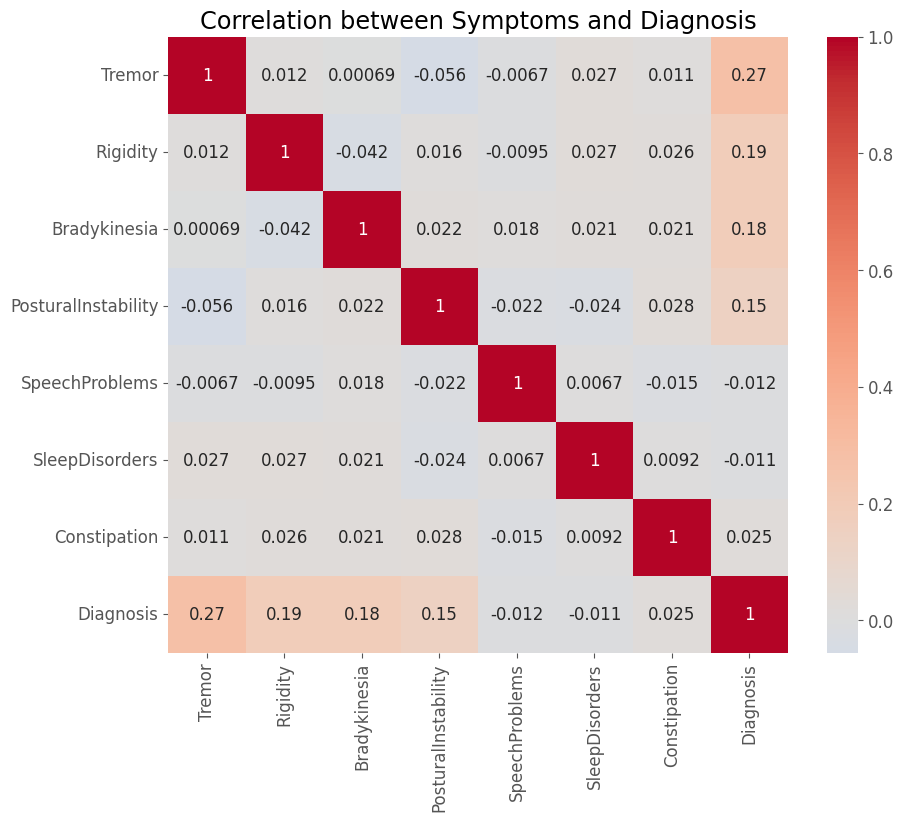

In [ ]:
# Correlation between symptoms and diagnosis
symptoms = ['Tremor', 'Rigidity', 'Bradykinesia', 'PosturalInstability', 'SpeechProblems', 'SleepDisorders', 'Constipation']
symptom_diagnosis_corr = df[symptoms + ['Diagnosis']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(symptom_diagnosis_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Symptoms and Diagnosis')
plt.show()

The heatmap shows that certain symptoms like tremor, rigidity, bradykinesia, and postural instability have weak to moderate positive correlations with the diagnosis of Parkinson's disease.
Other symptoms such as speech problems, sleep disorders, and constipation show very weak correlations with the diagnosis, suggesting they may not be strong indicators of Parkinson's in this dataset.

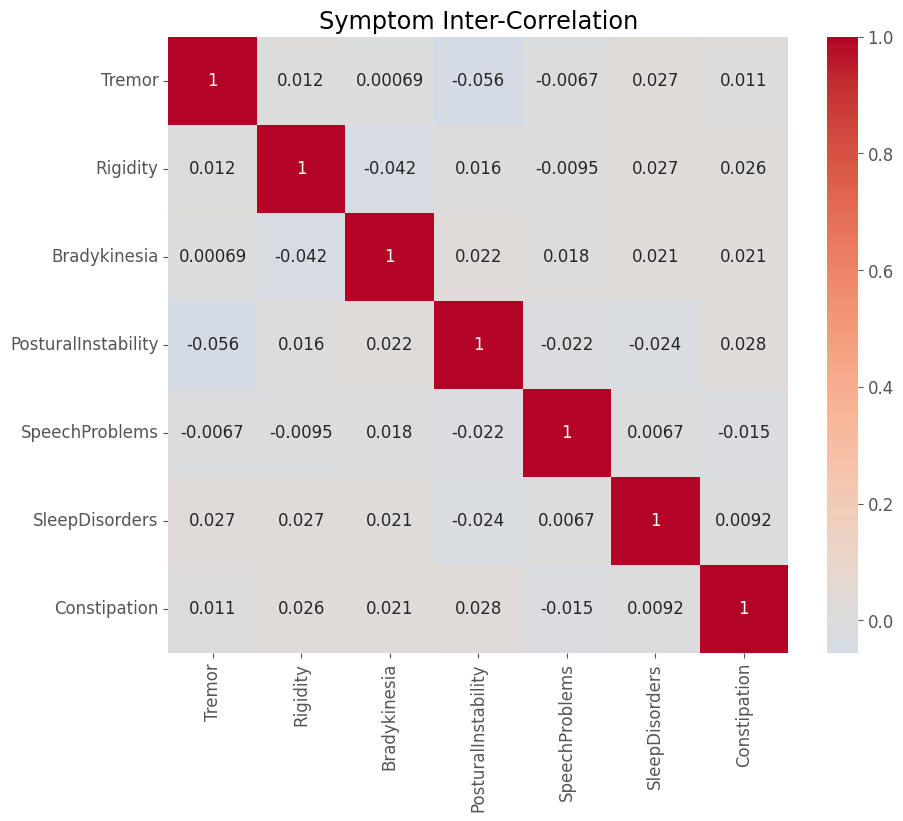

In [ ]:
# Correlation between different symptoms
symptom_corr = df[symptoms].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(symptom_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Symptom Inter-Correlation')
plt.show()

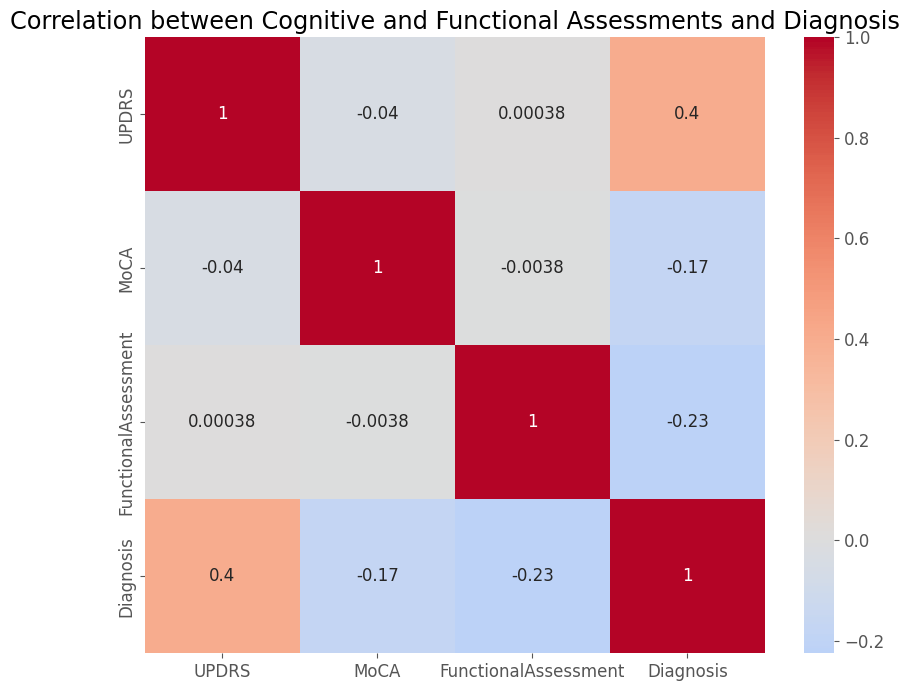

In [ ]:
# Correlation between coginitive funcitons and diagnosis
cognitive = ['UPDRS', 'MoCA', 'FunctionalAssessment']
cognitive_diagnosis_corr = df[cognitive + ['Diagnosis']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(cognitive_diagnosis_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Cognitive and Functional Assessments and Diagnosis')
plt.show()

In [ ]:
#tried to categorize the lifestyle data to see if that would help
#lifestyle = df[["BMI", "Smoking","AlcoholConsumption","PhysicalActivity","DietQuality","SleepQuality","Diagnosis"]]

In [ ]:
#added by Michelle
#lifestyle = df[["BMI", "Smoking","AlcoholConsumption","PhysicalActivity","DietQuality","SleepQuality","Diagnosis"]]
#lifestyle["Less than 4 Drinks/week"] = lifestyle['AlcoholConsumption'].apply(lambda x: 1 if x < 4 else 0)
#lifestyle["Moderate Exercise"] = lifestyle["PhysicalActivity"].apply(lambda x: 1 if x < 3.5 else 0)
#lifestyle["Quality Diet"] = lifestyle['DietQuality'].apply(lambda x: 1 if x < 3 else 0)
#lifestyle["Quality Sleep"] = lifestyle["SleepQuality"].apply(lambda x: 1 if x > 8 else 0)
#lifestyle

In [ ]:
# Correlation between lifestyle choices and diagnosis
##lsc = ['Less than 4 Drinks/week', 'Moderate Exercise', 'Quality Diet', 'Quality Sleep']
#lsc_corr = lifestyle[lsc + ['Diagnosis']].corr()

#plt.figure(figsize=(10, 8))
#sns.heatmap(lsc_corr, annot=True, cmap='coolwarm', center=0)
#plt.title('Correlation between lifestyle choices and Diagnosis')
#plt.show()

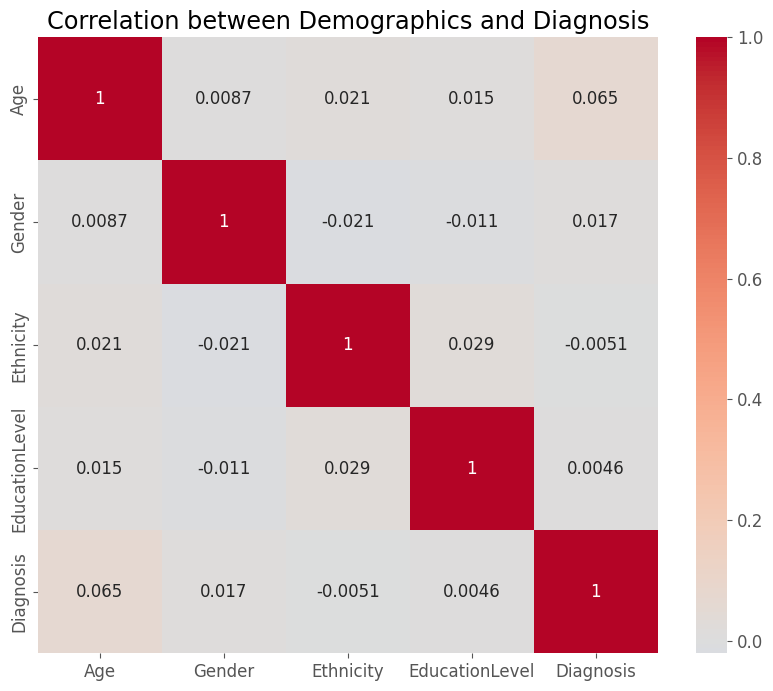

In [ ]:
#looking at demographic info
demo = ['Age', 'Gender', 'Ethnicity', 'EducationLevel']
demo_corr = df[demo + ['Diagnosis']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(demo_corr, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation between Demographics and Diagnosis')
plt.show()

In [ ]:
#built test for Random Forest (added by Michelle)
X = df[["Gender", "Ethnicity","EducationLevel","BMI","Smoking","AlcoholConsumption","PhysicalActivity","DietQuality","SleepQuality","FamilyHistoryParkinsons","TraumaticBrainInjury","Hypertension","Diabetes","Depression","Stroke","SystolicBP","DiastolicBP","CholesterolTotal","CholesterolLDL","CholesterolHDL","CholesterolTriglycerides","UPDRS","MoCA","FunctionalAssessment","Tremor","Rigidity","Bradykinesia","PosturalInstability","SpeechProblems","SleepDisorders","Constipation"]]
y = df["Diagnosis"]
print(X.shape)
print(y.shape)

(2105, 31)
(2105,)


                              BMI   Smoking  FamilyHistoryParkinsons  \
BMI                      1.000000 -0.008026                 0.034808   
Smoking                 -0.008026  1.000000                 0.026507   
FamilyHistoryParkinsons  0.034808  0.026507                 1.000000   
TraumaticBrainInjury    -0.033708 -0.024969                 0.036364   
Hypertension             0.005159  0.002929                -0.018205   
Diabetes                -0.016036  0.030774                 0.005670   
Depression              -0.038414  0.020449                -0.006680   
Stroke                  -0.020902  0.026362                 0.018582   
Diagnosis                0.030114  0.005241                 0.013363   

                         TraumaticBrainInjury  Hypertension  Diabetes  \
BMI                                 -0.033708      0.005159 -0.016036   
Smoking                             -0.024969      0.002929  0.030774   
FamilyHistoryParkinsons              0.036364     -0.018205 

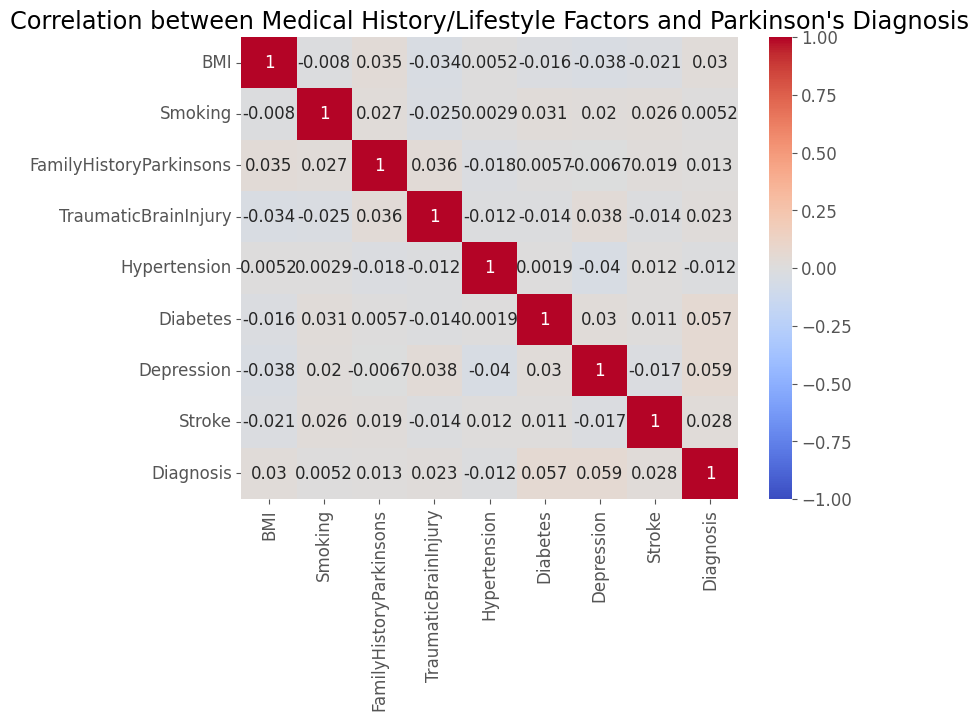

In [ ]:
# Medical history and lifestyle factors
factors = ['BMI', 'Smoking', 'FamilyHistoryParkinsons','TraumaticBrainInjury','Hypertension','Diabetes','Depression','Stroke']

# Add a column for Parkinson's diagnosis (assuming 'diagnosis' column exists)
#df['diagnosis'] = df['Diagnosis'].apply(lambda x: 1 if x == 'Positive' else 0)

# Calculate correlations
correlations = df[factors + ['Diagnosis']].corr()
print(correlations)

# Visualize correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Medical History/Lifestyle Factors and Parkinson\'s Diagnosis')
plt.show()

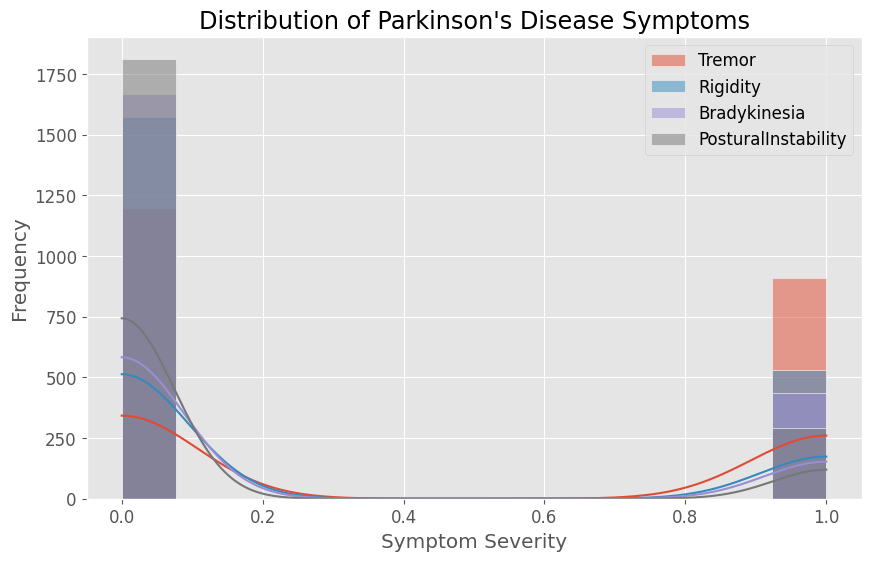

        SystolicBP       Stroke          BMI    Diagnosis
count  2105.000000  2105.000000  2105.000000  2105.000000
mean    133.719715     0.048931    27.209493     0.619477
std      26.502355     0.215775     7.208099     0.485631
min      90.000000     0.000000    15.008333     0.000000
25%     110.000000     0.000000    20.782176     0.000000
50%     133.000000     0.000000    27.184571     1.000000
75%     157.000000     0.000000    33.462452     1.000000
max     179.000000     1.000000    39.999887     1.000000


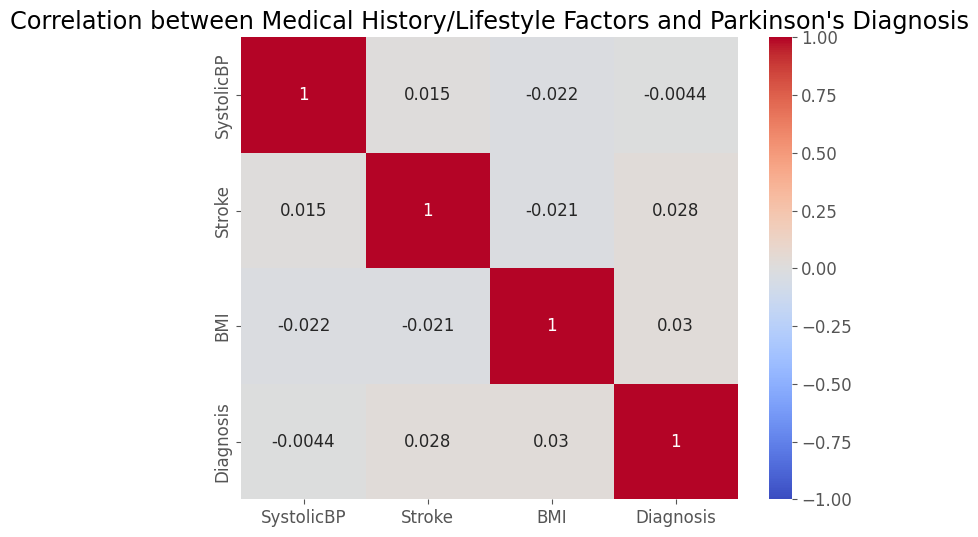

In [ ]:
# Descriptive statistics of symptoms
symptoms = ['Tremor', 'Rigidity', 'Bradykinesia', 'PosturalInstability']
symptom_stats = df[symptoms].describe()

# Visualize the distribution of symptoms
plt.figure(figsize=(10, 6))
for symptom in symptoms:
    sns.histplot(df[symptom], kde=True, label=symptom)
plt.legend()
plt.title('Distribution of Parkinson\'s Disease Symptoms')
plt.xlabel('Symptom Severity')
plt.ylabel('Frequency')
plt.show()

# Medical history and lifestyle factors
factors = ['SystolicBP', 'Stroke', 'BMI']

# Add a column for Parkinson's diagnosis (assuming 'diagnosis' column exists)
#df['diagnosis'] = df['Diagnosis'].apply(lambda x: 1 if x == 'Positive' else 0)

# Calculate correlations
correlations = df[factors + ['Diagnosis']].corr()

print(df[factors + ['Diagnosis']].describe())

# Visualize correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between Medical History/Lifestyle Factors and Parkinson\'s Diagnosis')
plt.show()

# Machine learning models

In [ ]:
# Reload csv

raw = pd.read_csv("parkinsons_disease_data.csv")


In [ ]:
# Convert categorical variables to numerical ones using LabelEncoder.

label_encoders = {}
for column in raw.select_dtypes(include=['object']).columns:
    if column != 'Diagnosis':  # Skip the target variable
        le = LabelEncoder()
        raw[column] = le.fit_transform(raw[column])
        label_encoders[column] = le

In [ ]:
# Prepare df that does not include PatientID and DoctorInCharge

df_1 = raw.drop(columns=['PatientID', 'DoctorInCharge'])


In [ ]:
# Prepare df that does not include Assessments or Symptoms

noAssess_noSymp = df_1.drop(columns=['UPDRS', 'MoCA', 'FunctionalAssessment', 'Tremor', 'Rigidity', 'Bradykinesia', 'PosturalInstability', 'SpeechProblems', 'SleepDisorders', 'Constipation'])


In [ ]:
# df_1 - Split data into training and test sets

x_1 = df_1.drop(columns=['Diagnosis'])
y_1 = df_1['Diagnosis']

# Test data size is 20% of total - random state set for consistency, stratify=y set to maintain proportion of diagnosis = Y and diagnosis = N

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(x_1, y_1, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# noAssess_noSymp - Split data into training and test sets

x_noAnoS = noAssess_noSymp.drop(columns=['Diagnosis'])
y_noAnoS = noAssess_noSymp['Diagnosis']

# Test data size is 20% of total - random state set for consistency, stratify=y set to maintain proportion of diagnosis = Y and diagnosis = N

x_train_noAssess_noSymp, x_test_noAssess_noSymp, y_train_noAssess_noSymp, y_test_noAssess_noSymp = train_test_split(x_noAnoS, y_noAnoS, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Scale features for df_1

scaler = StandardScaler()
x_train_1 = scaler.fit_transform(x_train_1)
x_test_1 = scaler.transform(x_test_1)

In [ ]:
# Scale features for noAssess_noSymp

scaler = StandardScaler()
x_train_noAssess_noSymp = scaler.fit_transform(x_train_noAssess_noSymp)
x_test_noAssess_noSymp = scaler.transform(x_test_noAssess_noSymp)

## Random Forest

In [ ]:
# df_1 - Initialize and train model

rf_1 = RandomForestClassifier(n_estimators=100, random_state=42)
rf_1.fit(x_train_1, y_train_1)

In [ ]:
# noAssess_noSymp - Initialize and train model

rf_noAssess_noSymp = RandomForestClassifier(n_estimators=100, random_state=42)
rf_noAssess_noSymp.fit(x_train_noAssess_noSymp, y_train_noAssess_noSymp)

RandomForestClassifier(random_state=42)

In [ ]:
# df_1 - Make predictions

y_pred_1 = rf_1.predict(x_test_1)

In [ ]:
# noAssess_noSymp - Make predictions

y_pred_noAssess_noSymp = rf_noAssess_noSymp.predict(x_test_noAssess_noSymp)

In [ ]:
# df_1 - Review accuracy

print("Accuracy:", accuracy_score(y_test_1, y_pred_1))
df_1_accuracy = accuracy_score(y_test_1, y_pred_1)
print("Classification Report:\n", classification_report(y_test_1, y_pred_1))

Accuracy: 0.9311163895486936
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91       160
           1       0.94      0.95      0.94       261

    accuracy                           0.93       421
   macro avg       0.93      0.93      0.93       421
weighted avg       0.93      0.93      0.93       421



In [ ]:
# noAssess_noSymp - Review accuracy

print("Accuracy:", accuracy_score(y_test_noAssess_noSymp, y_pred_noAssess_noSymp))
noAssess_noSymp_accuracy = accuracy_score(y_test_noAssess_noSymp, y_pred_noAssess_noSymp)
print("Classification Report:\n", classification_report(y_test_noAssess_noSymp, y_pred_noAssess_noSymp))

Accuracy: 0.6057007125890737
Classification Report:
               precision    recall  f1-score   support

           0       0.45      0.17      0.25       160
           1       0.63      0.87      0.73       261

    accuracy                           0.61       421
   macro avg       0.54      0.52      0.49       421
weighted avg       0.56      0.61      0.55       421



In [ ]:
# df_1 - Feature importance

feature_importances_1 = pd.DataFrame(rf_1.feature_importances_, index=x_1.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances_1)

                          importance
UPDRS                       0.228383
FunctionalAssessment        0.096669
MoCA                        0.078630
Tremor                      0.070083
DietQuality                 0.034928
SleepQuality                0.033312
Bradykinesia                0.032984
CholesterolTriglycerides    0.032783
Rigidity                    0.032087
CholesterolTotal            0.031830
PhysicalActivity            0.031608
Age                         0.031436
CholesterolHDL              0.031313
AlcoholConsumption          0.031003
CholesterolLDL              0.030897
BMI                         0.029222
SystolicBP                  0.028488
DiastolicBP                 0.028222
PosturalInstability         0.023733
EducationLevel              0.010824
Ethnicity                   0.008604
Depression                  0.005103
Gender                      0.004852
SleepDisorders              0.004628
Constipation                0.004489
Smoking                     0.004424
D

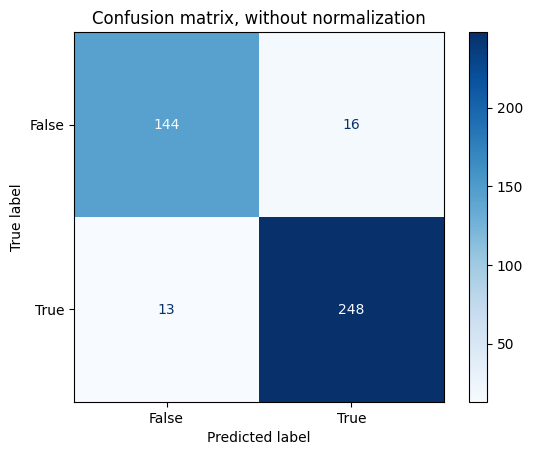

In [ ]:
with plt.style.context("default"): #temporarily set the plot style
    disp = ConfusionMatrixDisplay.from_estimator(
        rf_1,
        x_test_1,
        y_test_1,
        display_labels=[False, True],
        cmap=plt.cm.Blues,
        normalize=None,
    )
    disp.ax_.set_title("Confusion matrix, without normalization")

<ipython-input-69-5b53051aaf2a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='importance', y=feature_importances_1.index, data=feature_importances_1, palette="summer")


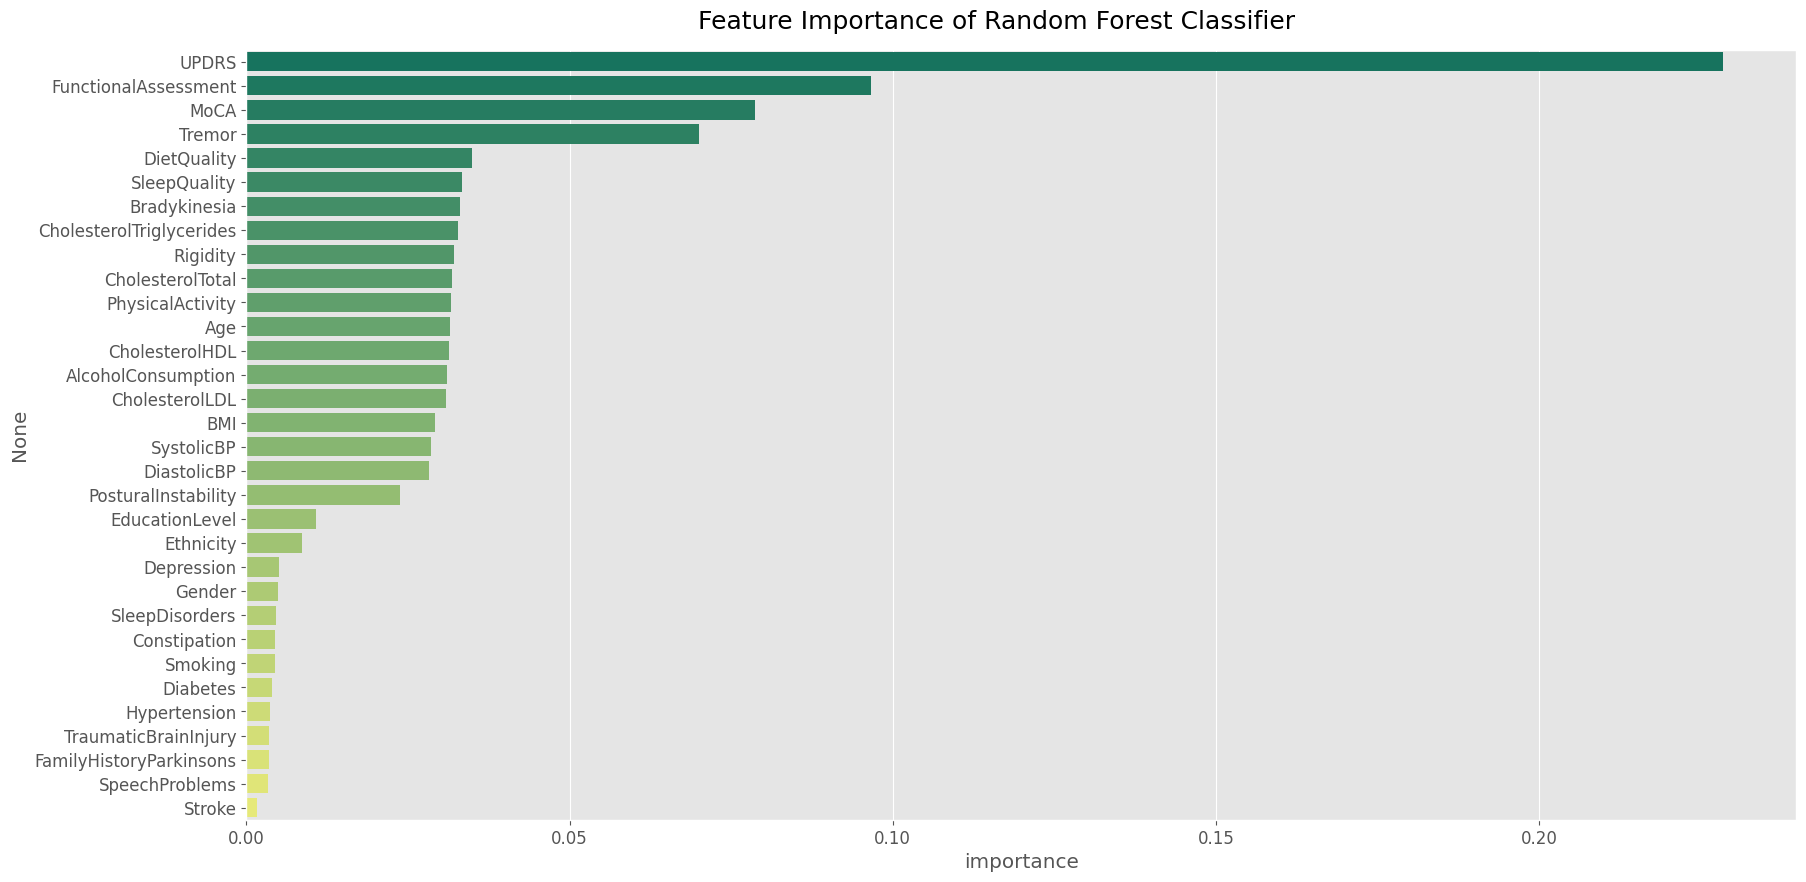

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = sns.barplot(x='importance', y=feature_importances_1.index, data=feature_importances_1, palette="summer")
fig.suptitle("Feature Importance of Random Forest Classifier", y=0.92, fontsize=18);

In [ ]:
# noAssess_noSymp - Feature importance

feature_importances_2 = pd.DataFrame(rf_noAssess_noSymp.feature_importances_, index=x_noAnoS.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances_2)

                          importance
BMI                         0.080223
CholesterolTriglycerides    0.079415
SleepQuality                0.078634
CholesterolTotal            0.077443
DietQuality                 0.076604
AlcoholConsumption          0.075898
CholesterolHDL              0.075193
CholesterolLDL              0.073571
PhysicalActivity            0.067767
Age                         0.067608
SystolicBP                  0.066286
DiastolicBP                 0.066245
EducationLevel              0.025137
Ethnicity                   0.019493
Gender                      0.012138
Depression                  0.011487
Smoking                     0.010240
Hypertension                0.008867
Diabetes                    0.008419
FamilyHistoryParkinsons     0.007666
TraumaticBrainInjury        0.006801
Stroke                      0.004866


<ipython-input-90-edb51468a8b6>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='importance', y=feature_importances_2.index, data=feature_importances_2, palette="summer")


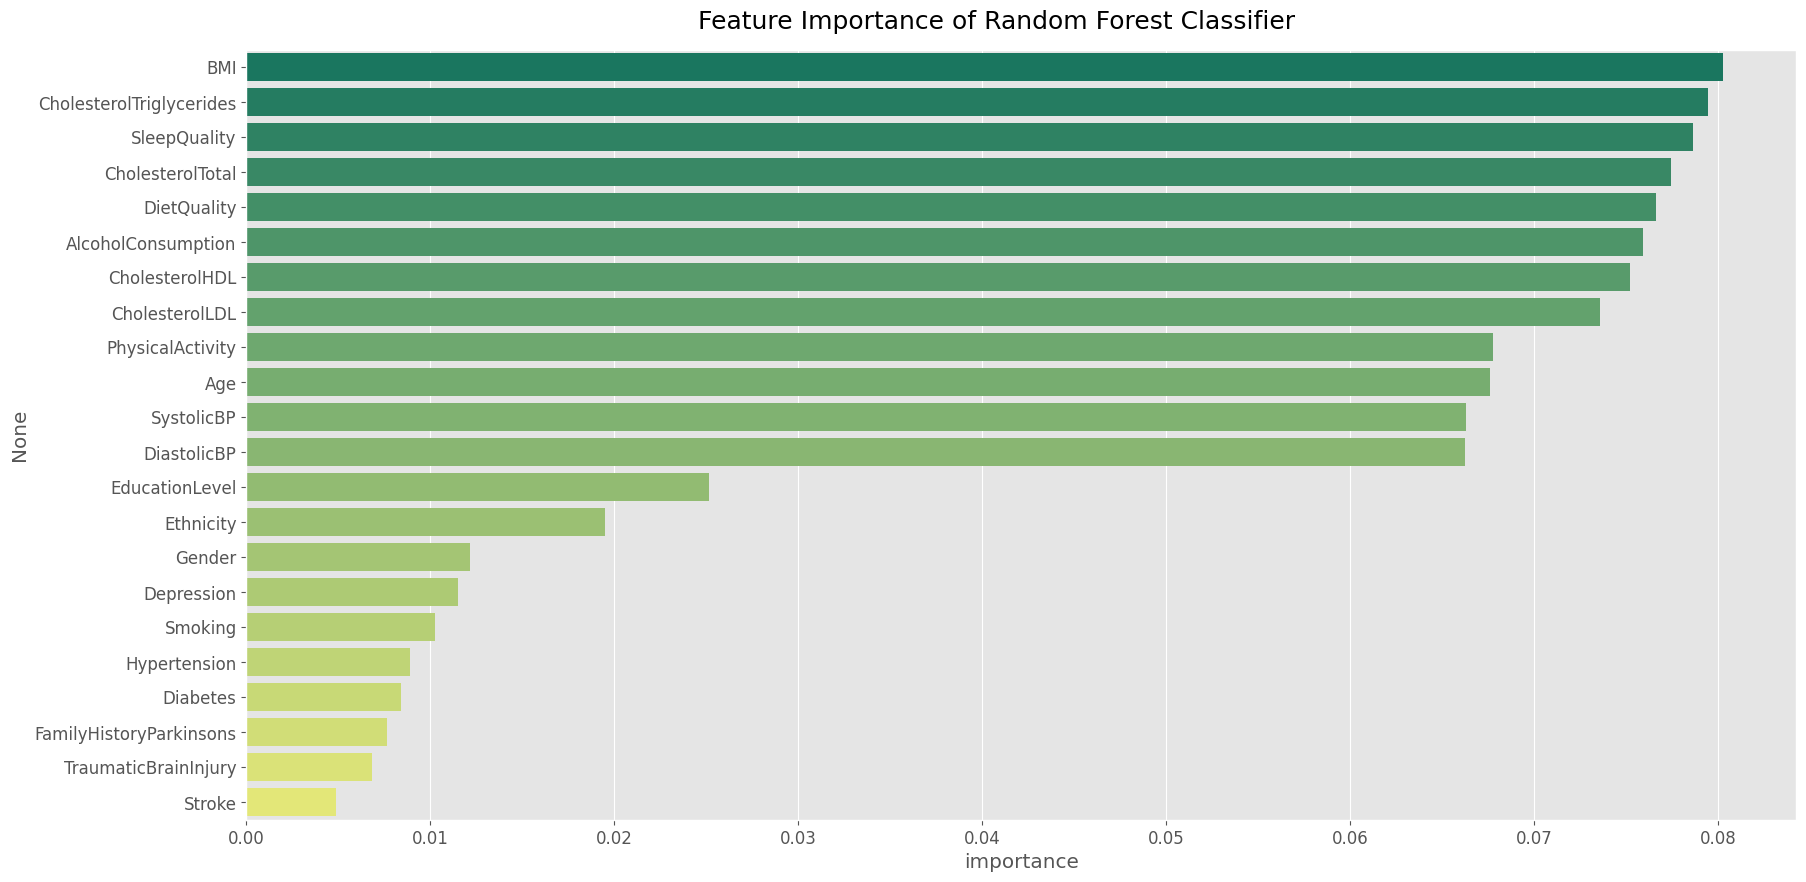

In [ ]:
fig = plt.figure(figsize=(20,10))
ax = sns.barplot(x='importance', y=feature_importances_2.index, data=feature_importances_2, palette="summer")
fig.suptitle("Feature Importance of Random Forest Classifier", y=0.92, fontsize=18);

### Model Tuning - GridSearchCV

Test DF1 - which includes attributes 'UPDRS', 'MoCA', 'FunctionalAssessment', 'Tremor', 'Rigidity', 'Bradykinesia', 'PosturalInstability', 'SpeechProblems', 'SleepDisorders', 'Constipation'

In [ ]:
param_grid2 = {
    'n_estimators': [150,200,300],
    'max_features': ['sqrt',  None],
    'bootstrap':[False, True]
}

grid_search2 = GridSearchCV(RandomForestClassifier(),
                           param_grid=param_grid2)
grid_search2.fit(x_train_1, y_train_1)
print(grid_search2.best_estimator_)

RandomForestClassifier(bootstrap=False, n_estimators=300)


In [ ]:
# take the recommended parameters from the Grid Search and run the Random Forest again

rf_1_GSV = RandomForestClassifier(n_estimators=300,bootstrap=False)
rf_1_GSV.fit(x_train_1, y_train_1)

RandomForestClassifier(bootstrap=False, n_estimators=300)

In [ ]:
#Make predictions
y_pred_1_GSV = rf_1_GSV.predict(x_test_1)

In [ ]:
# df_1 - Review accuracy

print("Accuracy tuned model:", accuracy_score(y_test_1, y_pred_1_GSV ), "vs original model", df_1_accuracy)
print("Classification Report:\n", classification_report(y_test_1, y_pred_1_GSV ))

Accuracy tuned model: 0.9429928741092637 vs original model 0.9311163895486936
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.93      0.93       160
           1       0.95      0.95      0.95       261

    accuracy                           0.94       421
   macro avg       0.94      0.94      0.94       421
weighted avg       0.94      0.94      0.94       421



Test noAssess_noSymp model

In [ ]:
grid_search = GridSearchCV(RandomForestClassifier(),
                           param_grid=param_grid2)
grid_search.fit(x_train_noAssess_noSymp, y_train_noAssess_noSymp)
print(grid_search.best_estimator_)

RandomForestClassifier(n_estimators=200)


In [ ]:
# noAssess_noSymp - Initialize and train model

rf_noAssess_noSymp_GSV = RandomForestClassifier(n_estimators=200)
rf_noAssess_noSymp_GSV.fit(x_train_noAssess_noSymp, y_train_noAssess_noSymp)

RandomForestClassifier(n_estimators=200)

In [ ]:
# noAssess_noSymp - Make predictions

y_pred_noAssess_noSymp_GSV = rf_noAssess_noSymp_GSV.predict(x_test_noAssess_noSymp)

In [ ]:
# noAssess_noSymp - Review accuracy

print("Accuracy:", accuracy_score(y_test_noAssess_noSymp, y_pred_noAssess_noSymp_GSV), "vs Original Model",noAssess_noSymp_accuracy )
print("Classification Report:\n", classification_report(y_test_noAssess_noSymp, y_pred_noAssess_noSymp_GSV))

Accuracy: 0.5795724465558195 vs Original Model 0.6057007125890737
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.10      0.15       160
           1       0.61      0.87      0.72       261

    accuracy                           0.58       421
   macro avg       0.47      0.49      0.44       421
weighted avg       0.50      0.58      0.50       421



## Logistic Regression

([<matplotlib.axis.XTick at 0x780417daff70>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15')])

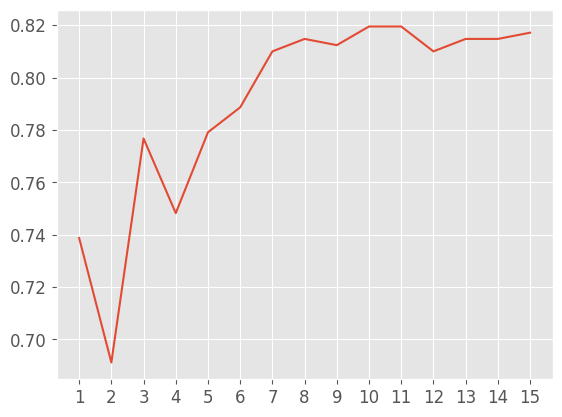

In [ ]:


# k = 5
n_value=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]


def fs(n):
    score=[]
    x_new = SelectKBest(f_classif, k=n).fit_transform(x_1, y_1)
    for i in range(10):
        x_train, x_test, y_train, y_test = train_test_split(x_new, y_1, test_size=0.2, random_state=42, stratify=y)
        lr = LogisticRegression(solver='newton-cg')
        lr.fit(x_train,y_train)
        # Predict the target values on the testing set
        y_pred = lr.predict(x_test)

        # Calculate the R^2 score
        r2 = lr.score(x_test, y_test)
        score.append(r2)
    return(score)

n_score=[]
for n in n_value:
    n_score.append(np.average(fs(n)))

plt.plot(n_value,n_score)
plt.xticks(n_value)

In [ ]:
selector = SelectKBest(f_classif, k=10)
selector.fit(x_1, y_1)
# Get columns to keep and create new dataframe with those only
cols_idxs = selector.get_support(indices=True)
features_df_new = x_1.iloc[:,cols_idxs]

features_df_new

,Age,Diabetes,Depression,UPDRS,MoCA,FunctionalAssessment,Tremor,Rigidity,Bradykinesia,PosturalInstability
0,85,0,0,6.458713,29.181289,1.572427,1,0,0,0
1,75,0,0,37.306703,12.332639,4.787551,0,1,0,1
2,70,1,0,67.838170,29.927783,2.130686,1,0,0,0
3,52,0,0,52.964696,21.304268,3.391288,1,1,1,0
4,87,0,0,21.804880,8.336364,3.200969,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
2100,87,0,0,187.887925,28.634010,8.076254,1,0,0,0
2101,67,0,0,172.325253,13.106537,1.665751,0,0,0,1
2102,65,1,0,111.851581,26.527734,4.785614,0,0,0,0
2103,61,0,0,144.474453,19.873404,8.378979,1,0,1,0


In [ ]:
x_train_t, x_test_t, y_train_t, y_test_t = train_test_split(features_df_new, y_1, test_size=0.2, random_state=42, stratify=y_1)

model_lr_1a = LogisticRegression(solver='newton-cg')
model_lr_1a.fit(x_train_t, y_train_t)
y_pred_1a = model_lr_1a.predict(x_test_t)
accuracy_lr_1a = model_lr_1a.score(x_test_t, y_test_t)
print(f'Accuracy: {accuracy_lr_1a}')

Accuracy: 0.8194774346793349


In [ ]:

logit_model=sm.Logit(y_1,features_df_new)
result=logit_model.fit()
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.393383
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:              Diagnosis   No. Observations:                 2105
Model:                          Logit   Df Residuals:                     2095
Method:                           MLE   Df Model:                            9
Date:                Mon, 12 Aug 2024   Pseudo R-squ.:                  0.4078
Time:                        19:10:06   Log-Likelihood:                -828.07
converged:                       True   LL-Null:                       -1398.4
Covariance Type:            nonrobust   LLR p-value:                7.874e-240
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Age                     -0.0099      0.003     -3.778      0.000      -0.015      -0.005

([<matplotlib.axis.XTick at 0x780417a9ded0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12')])

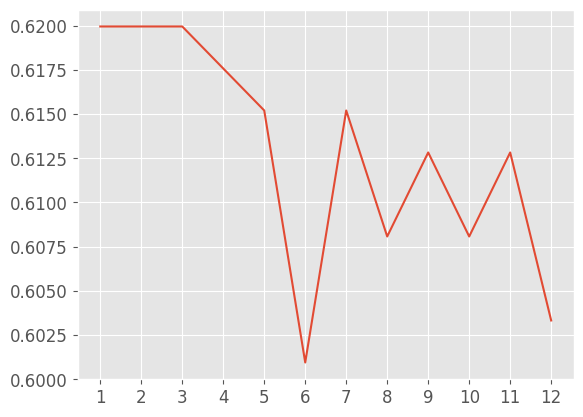

In [ ]:
n_value=[1,2,3,4,5,6,7,8,9,10,11,12]


def fs(n):
    score=[]
    x_new = SelectKBest(f_classif, k=n).fit_transform(x_noAnoS, y_noAnoS)
    for i in range(10):
        x_train, x_test, y_train, y_test = train_test_split(x_new, y_noAnoS, test_size=0.2, random_state=42, stratify=y)
        lr = LogisticRegression(solver='newton-cg')
        lr.fit(x_train,y_train)
        # Predict the target values on the testing set
        y_pred = lr.predict(x_test)

        # Calculate the R^2 score
        r2 = lr.score(x_test, y_test)
        score.append(r2)
    return(score)

n_score=[]
for n in n_value:
    n_score.append(np.average(fs(n)))

plt.plot(n_value,n_score)
plt.xticks(n_value)

In [ ]:
selector2 = SelectKBest(f_classif, k=3)
selector2.fit(x_noAnoS, y_noAnoS)
# Get columns to keep and create new dataframe with those only
cols_idxs2 = selector2.get_support(indices=True)
features_df_new2 = x_1.iloc[:,cols_idxs2]

features_df_new2

,Age,Diabetes,Depression
0,85,0,0
1,75,0,0
2,70,1,0
3,52,0,0
4,87,0,0
...,...,...,...
2100,87,0,0
2101,67,0,0
2102,65,1,0
2103,61,0,0


In [ ]:
x_train_t2, x_test_t2, y_train_t2, y_test_t2 = train_test_split(features_df_new2, y_noAnoS, test_size=0.2, random_state=42, stratify=y_1)

model_lr_2 = LogisticRegression(solver='newton-cg')

model_lr_2.fit(x_train_t2, y_train_t2)
y_pred_2 = model_lr_2.predict(x_test_t2)
accuracy_lr_2 = model_lr_2.score(x_test_t2, y_test_t2)
print(f'Accuracy: {accuracy_lr_2}')

Accuracy: 0.6199524940617577


In [ ]:
logit_model2=sm.Logit(y_noAnoS,features_df_new2)
result2=logit_model2.fit()
print(result2.summary())

Optimization terminated successfully.
         Current function value: 0.659371
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              Diagnosis   No. Observations:                 2105
Model:                          Logit   Df Residuals:                     2102
Method:                           MLE   Df Model:                            2
Date:                Mon, 12 Aug 2024   Pseudo R-squ.:                0.007449
Time:                        19:10:12   Log-Likelihood:                -1388.0
converged:                       True   LL-Null:                       -1398.4
Covariance Type:            nonrobust   LLR p-value:                 2.994e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Age            0.0057      0.001      7.599      0.000       0.004       0.007
Diabetes       0.3207      0.

## K-Nearest Neighbors

([<matplotlib.axis.XTick at 0x780417659390>,
 [Text(1, 0, '1'),
  Text(3, 0, '3'),
  Text(5, 0, '5'),
  Text(7, 0, '7'),
  Text(10, 0, '10'),
  Text(20, 0, '20'),
  Text(30, 0, '30'),
  Text(40, 0, '40'),
  Text(50, 0, '50')])

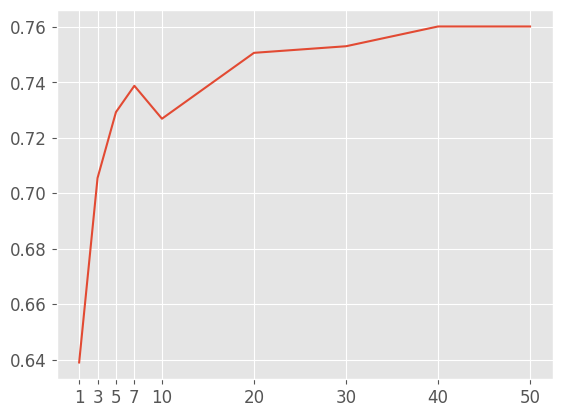

In [ ]:
# df_1 - KNN model

# k = 5
k_value=[1,3,5,7,10,20,30,40,50]


def knn(k):
    score=[]
    for i in range(10):
        x_train, x_test, y_train, y_test = train_test_split(x_1, y_1, test_size=0.2, random_state=42, stratify=y_1)
        neigh = KNeighborsClassifier(n_neighbors=k)
        neigh.fit(x_train, y_train)
        predicted=neigh.predict(x_test)
        score.append(neigh.score(x_test,y_test))
    return(score)

k_score=[]
for k in k_value:
    k_score.append(np.average(knn(k)))

plt.plot(k_value,k_score)
plt.xticks(k_value)


In [ ]:

model_knn_1 = KNeighborsClassifier(n_neighbors=40)
model_knn_1.fit(x_train_1, y_train_1)
y_pred_1 = model_knn_1.predict(x_test_1)
accuracy_knn_1 = model_knn_1.score(x_test_1, y_test_1)
print(f'Accuracy: {accuracy_knn_1}')

Accuracy: 0.7957244655581948


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
with plt.style.context("default"): #temporarily set the plot style
    disp = ConfusionMatrixDisplay.from_estimator(
        model_knn_1,
        x_test_1,
        y_test,
        display_labels=[False, True],
        cmap=plt.cm.Blues,
        normalize=None,
    )
    disp.ax_.set_title("Confusion matrix, without normalization")

NameError: name 'y_test' is not defined

In [ ]:
k_value=[1,3,5,7,10,20,30,40,50]


def knn(k):
    score=[]
    for i in range(10):
        x_train, x_test, y_train, y_test = train_test_split(x_noAnoS, y_noAnoS, test_size=0.2, random_state=42, stratify=y_1)
        neigh = KNeighborsClassifier(n_neighbors=k)
        neigh.fit(x_train, y_train)
        predicted=neigh.predict(x_test)
        score.append(neigh.score(x_test,y_test))
    return(score)

k_score=[]
for k in k_value:
    k_score.append(np.average(knn(k)))

plt.plot(k_value,k_score)
plt.xticks(k_value)

In [ ]:
# noAssess_noSymp - KNN model

# k = 5

model_knn_2 = KNeighborsClassifier(n_neighbors=50)
model_knn_2.fit(x_train_noAssess_noSymp, y_train_noAssess_noSymp)
y_pred_2 = model_knn_2.predict(x_test_noAssess_noSymp)
accuracy_knn_2 = model_knn_2.score(x_test_noAssess_noSymp, y_test_noAssess_noSymp)
print(f'Accuracy: {accuracy_knn_2}')